#  <center>**Maestría en Ciencia de Datos y Analítica**</center>
## <center>**Proyecto Integrador**</center>
### <center>**Autores**:</center>
##### <center>**Sebastian Carvalho Salazar**</center>
##### <center>**Daniel Loaiza López**</center>
##### <center>**Sebastian Ramirez Escobar**</center>
##### <center>**Javier Gonzalez Alvarez**</center>
##### <center>**Asmec Duvan Urrea Uribe**</center>


# Laboratorio de Modelos
---

# Librerias

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import itertools
import json
import os

from sklearn.metrics import r2_score, mean_squared_error

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore")

# Cargar datos
---

In [ ]:
df = pd.read_csv('/content/DataImputed.csv').drop('Unnamed: 0', axis=1)

# Arima Final
---

Linea: 1 - Hora: 8
Prueba de Dickey-Fuller:
Estadística de prueba: -2.5461123422589815
P-valor: 0.10465389313088752
Valores críticos: {'1%': -3.4377271455534597, '5%': -2.864796595407904, '10%': -2.5685040379415454}
Mejores órdenes: (8, 1, 9)
Mejor AIC: 14725.613474372449
Coeficiente de determinación (R²): 0.6832502560606699
Error cuadrático medio (RMSE): 747.4423220144414
Linea: 1 - Hora: 9
Prueba de Dickey-Fuller:
Estadística de prueba: -2.392284857545425
P-valor: 0.1439258016420814
Valores críticos: {'1%': -3.4377271455534597, '5%': -2.864796595407904, '10%': -2.5685040379415454}
Mejores órdenes: (6, 1, 9)
Mejor AIC: 14277.02328569325
Coeficiente de determinación (R²): 0.6355150909289462
Error cuadrático medio (RMSE): 508.06113133268127
Linea: 1 - Hora: 10
Prueba de Dickey-Fuller:
Estadística de prueba: -2.316903598980172
P-valor: 0.16657416581604712
Valores críticos: {'1%': -3.4377271455534597, '5%': -2.864796595407904, '10%': -2.5685040379415454}
Mejores órdenes: (6, 1, 9)
Mejor A

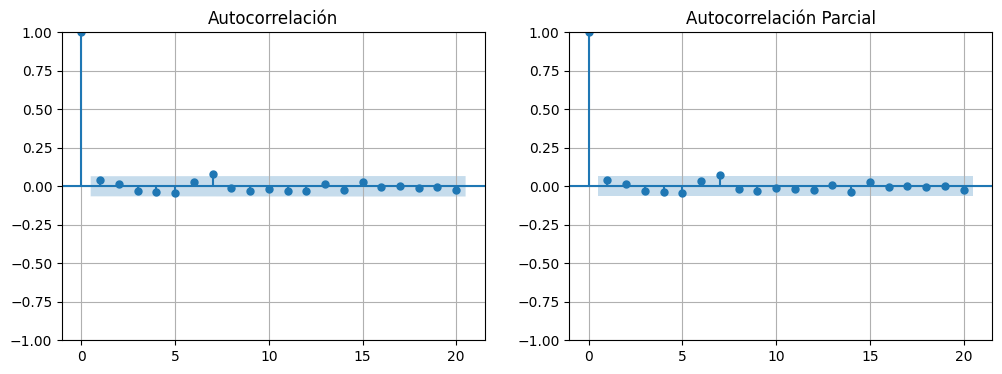

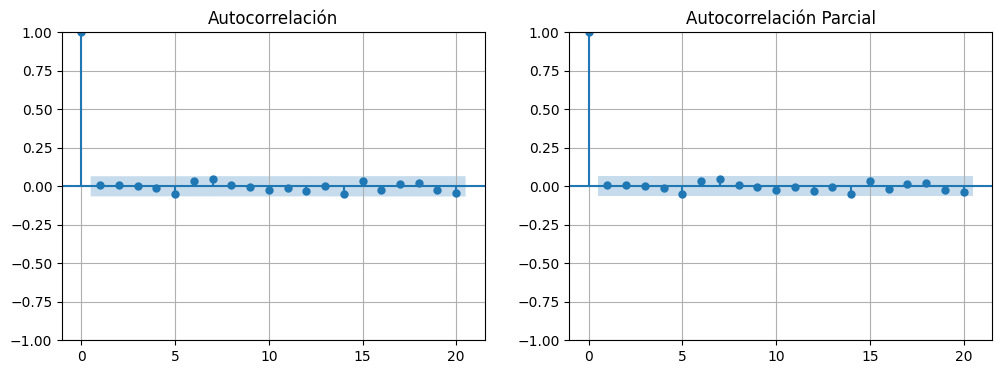

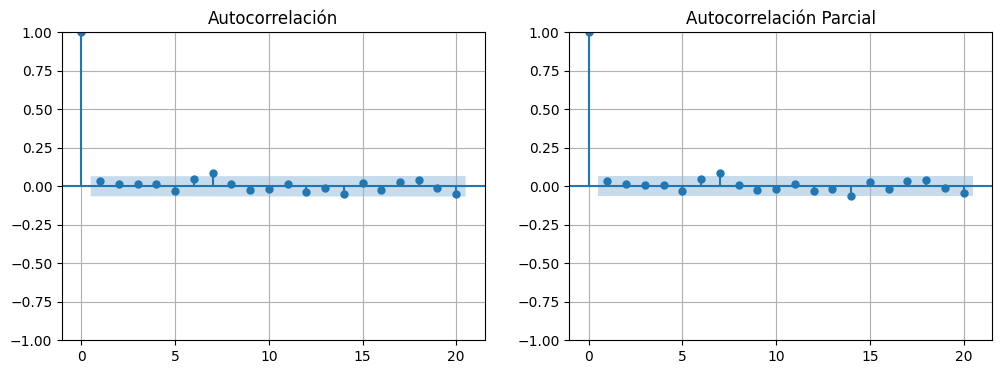

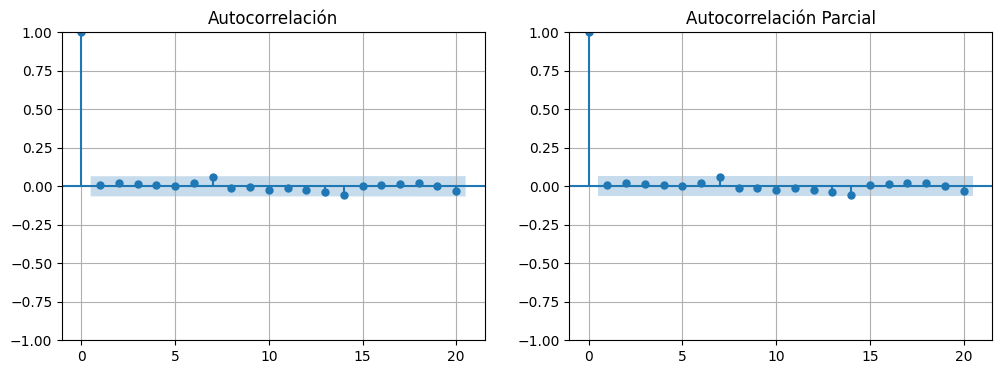

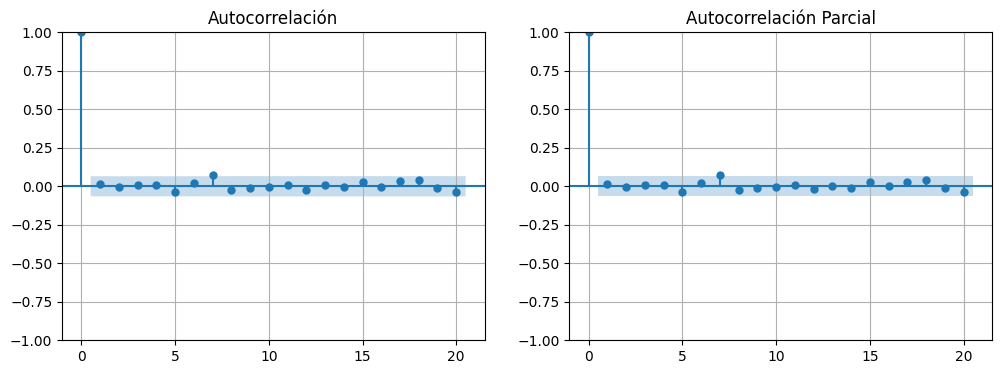

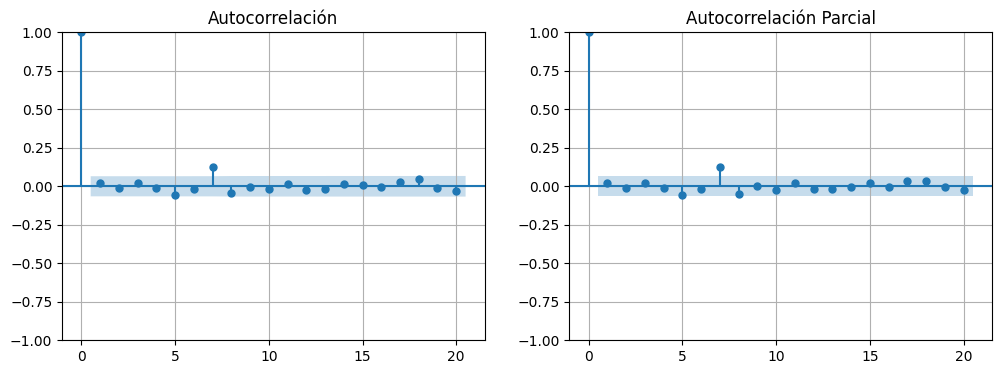

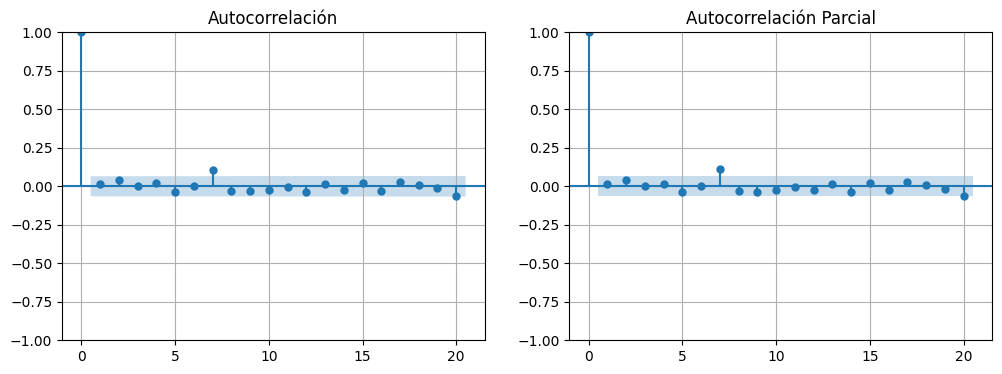

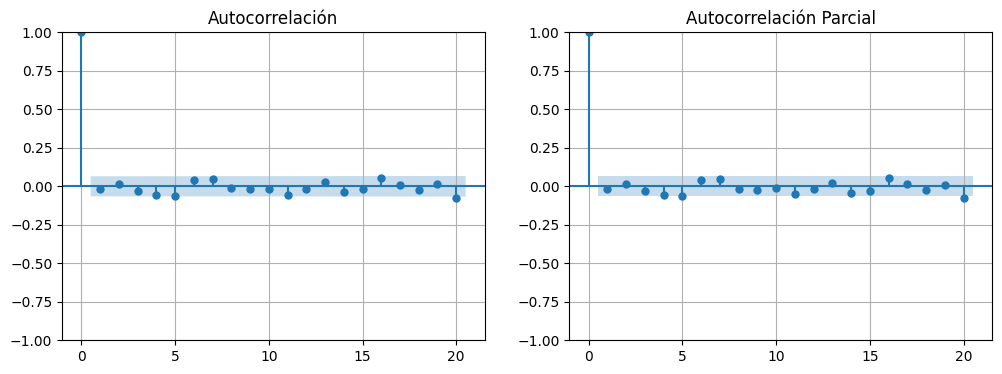

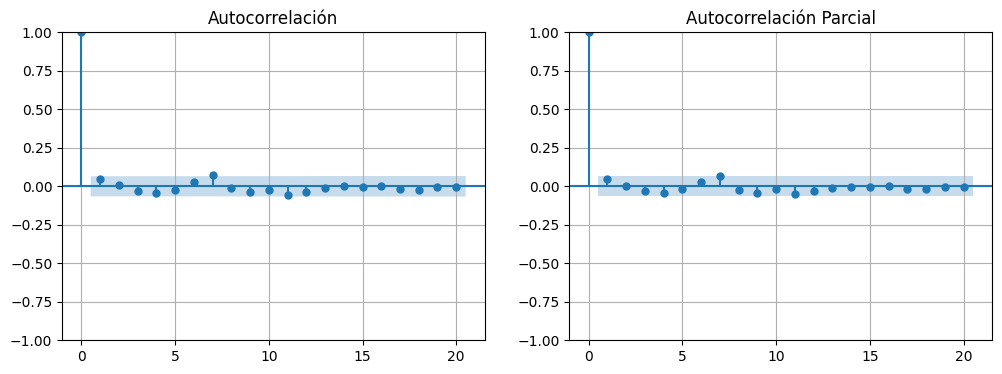

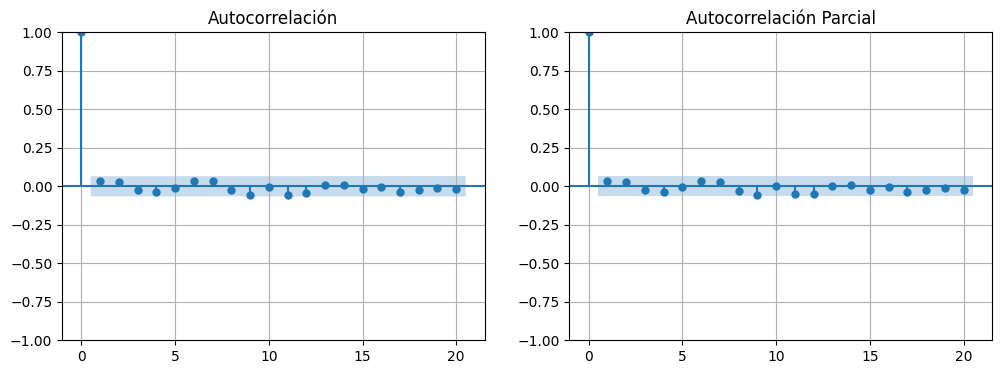

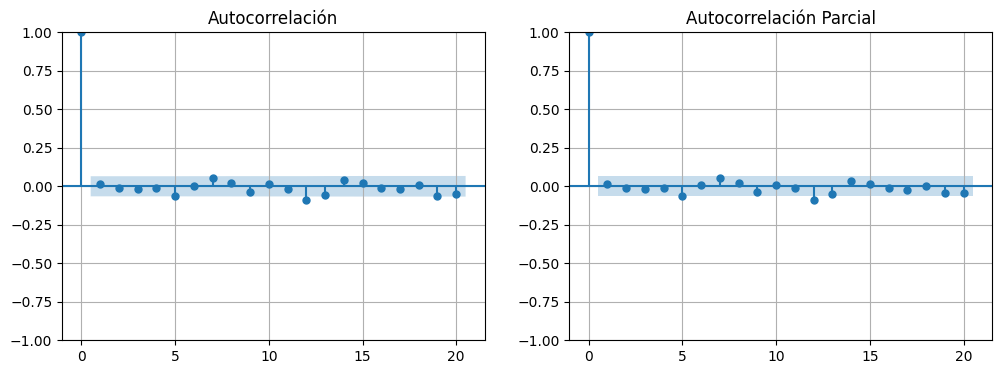

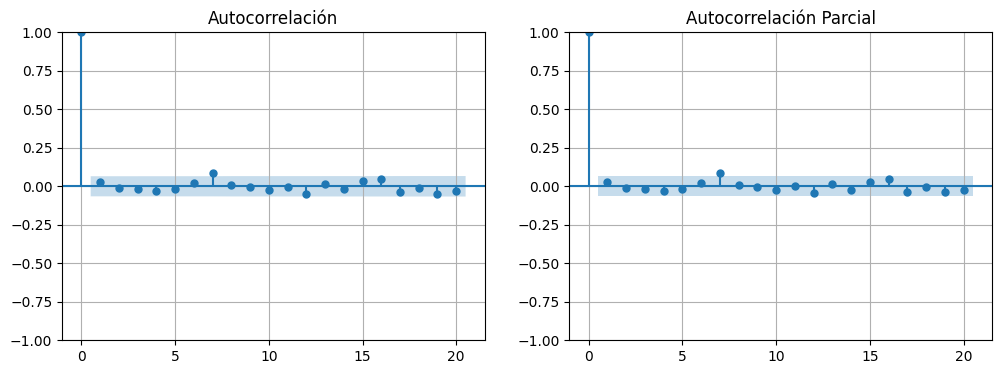

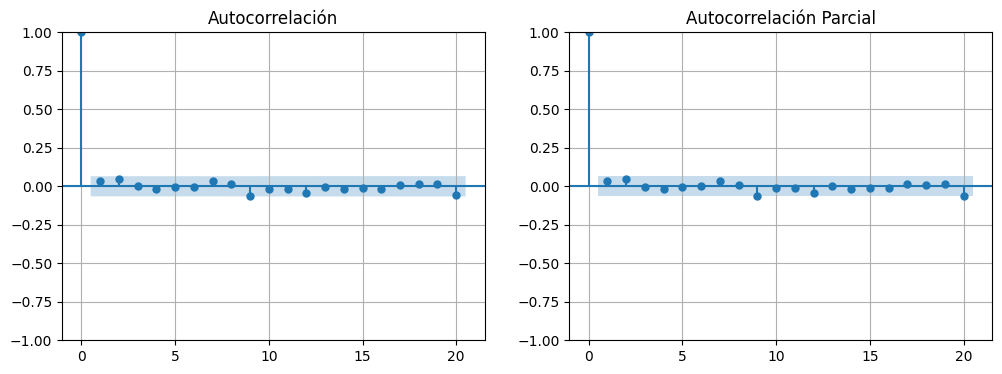

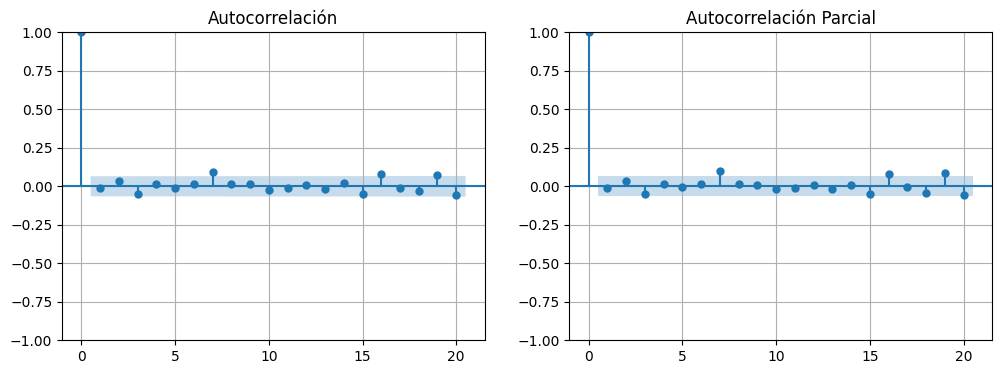

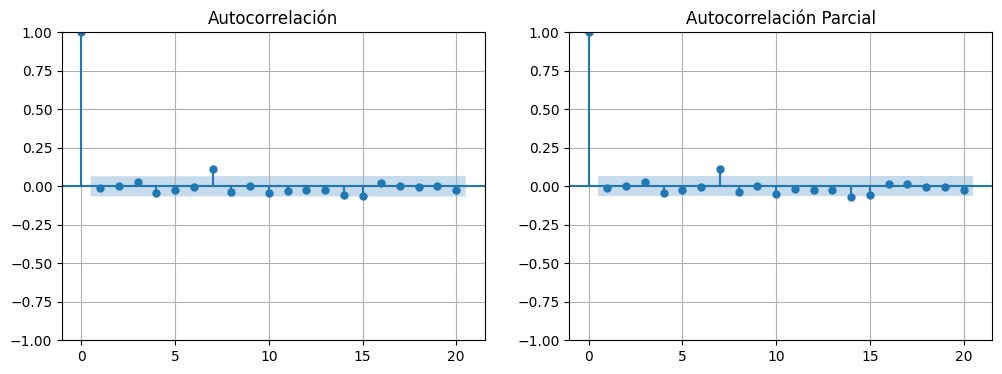

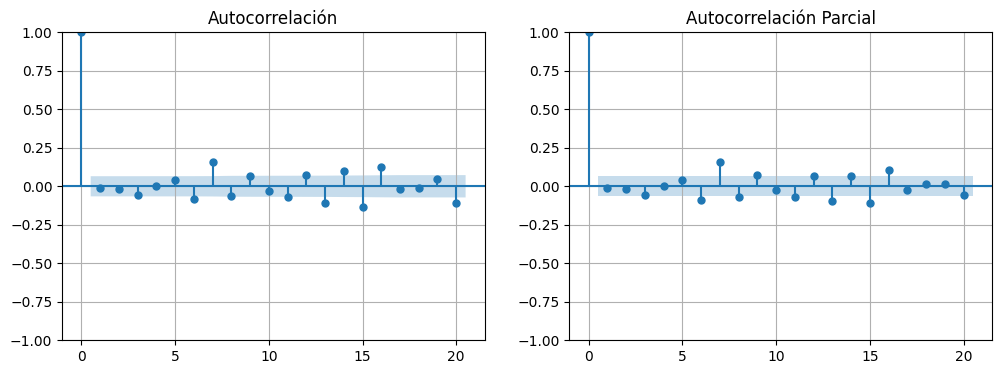

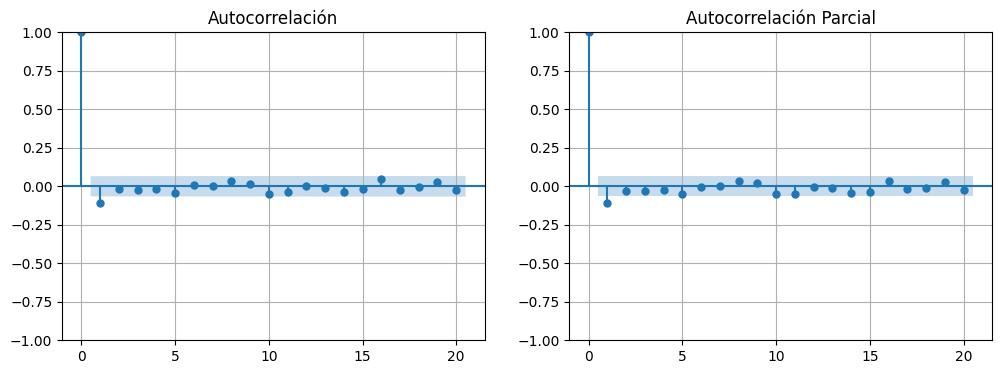

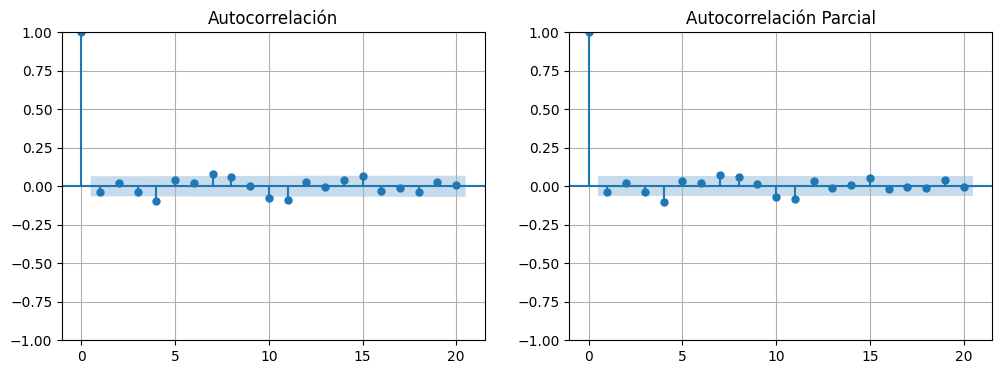

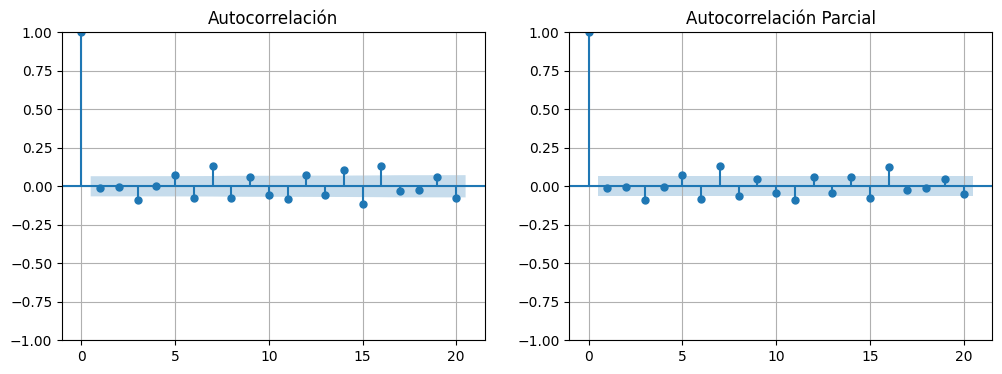

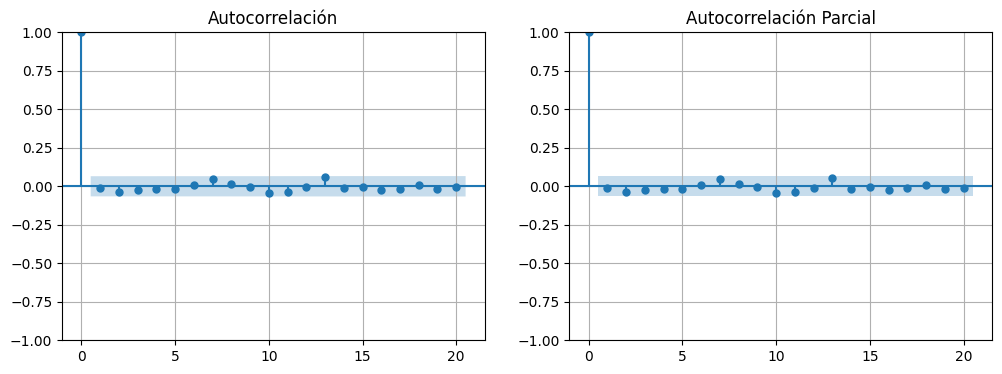

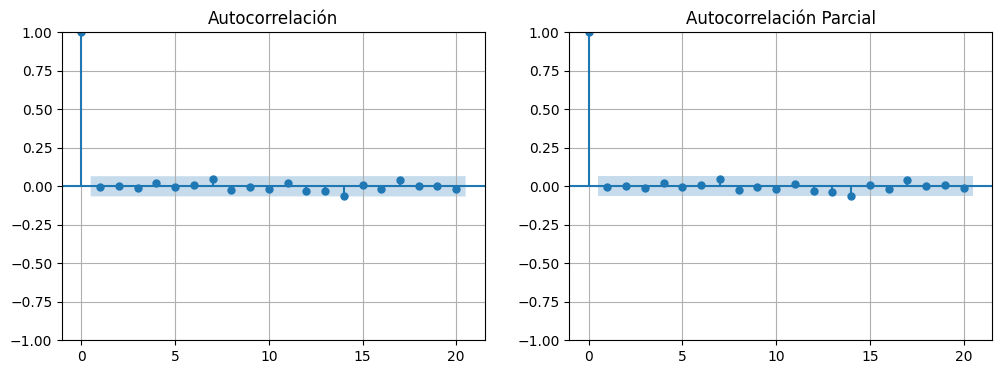

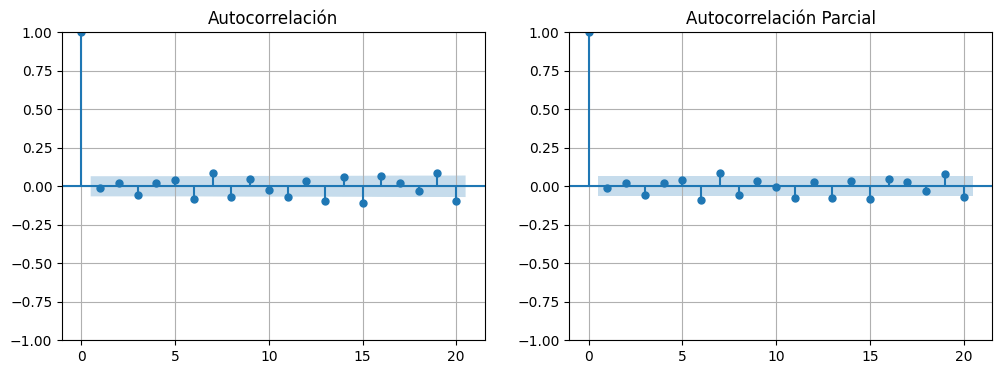

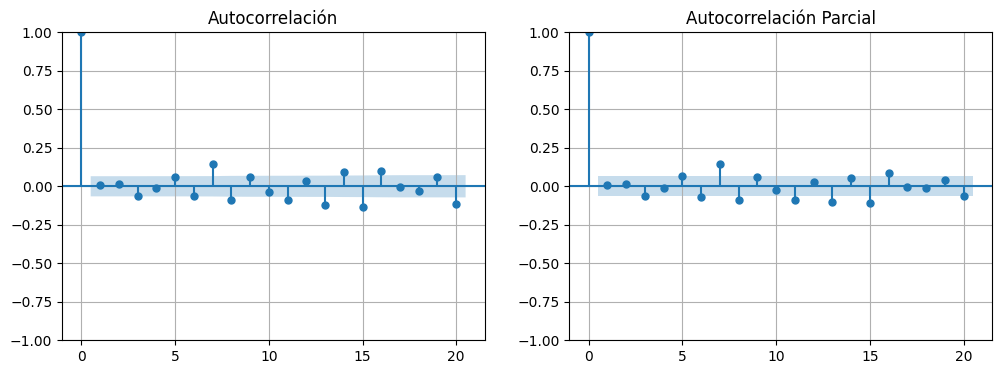

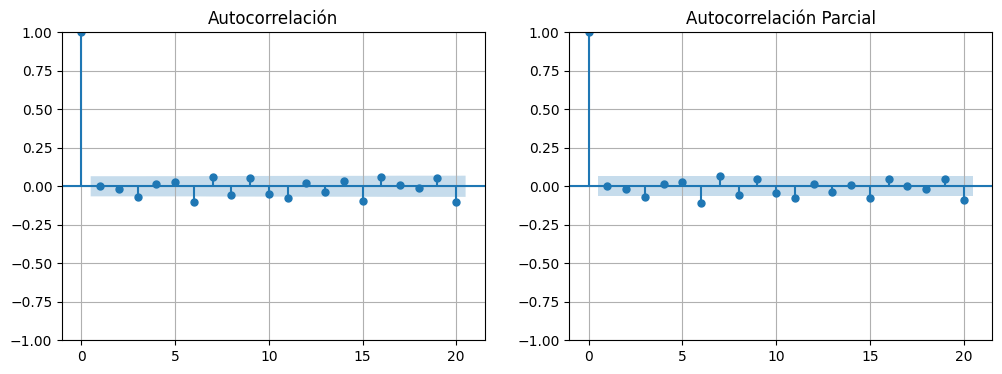

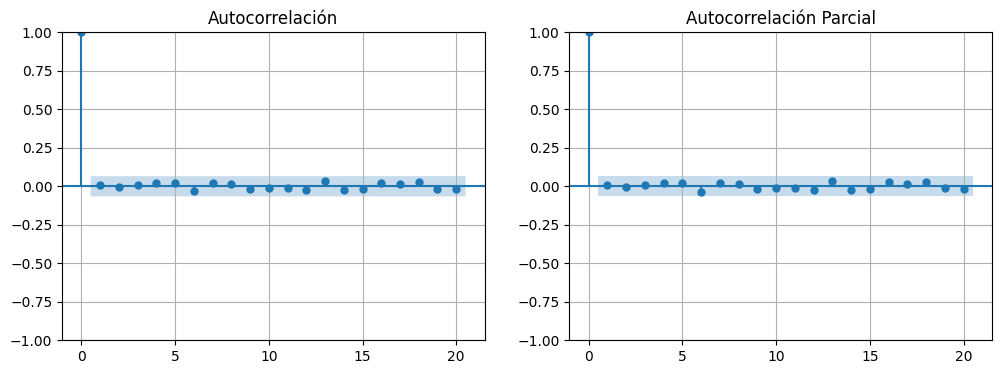

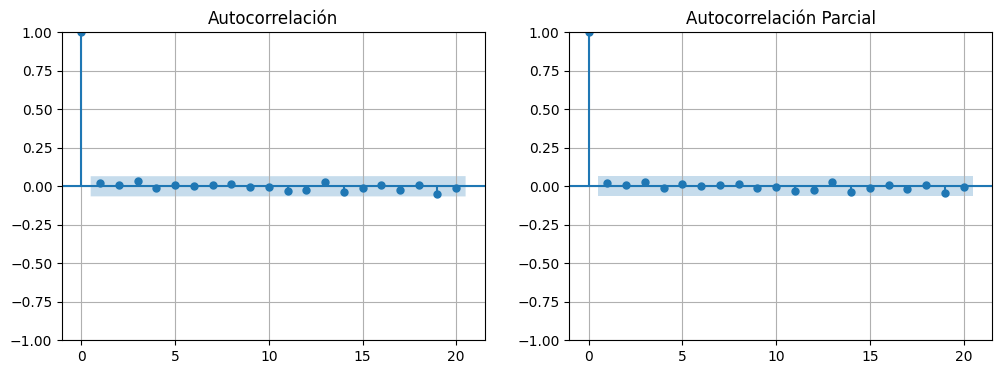

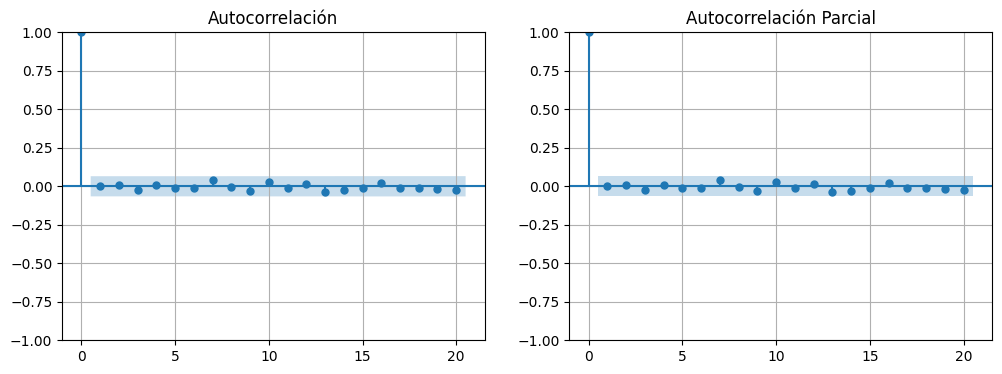

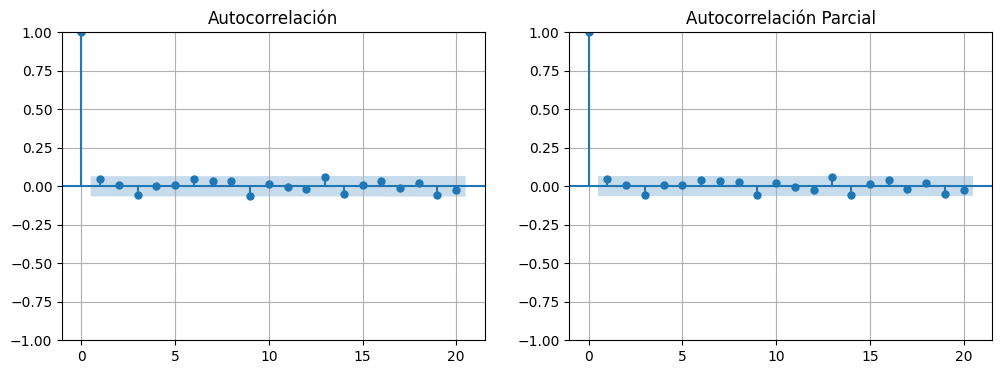

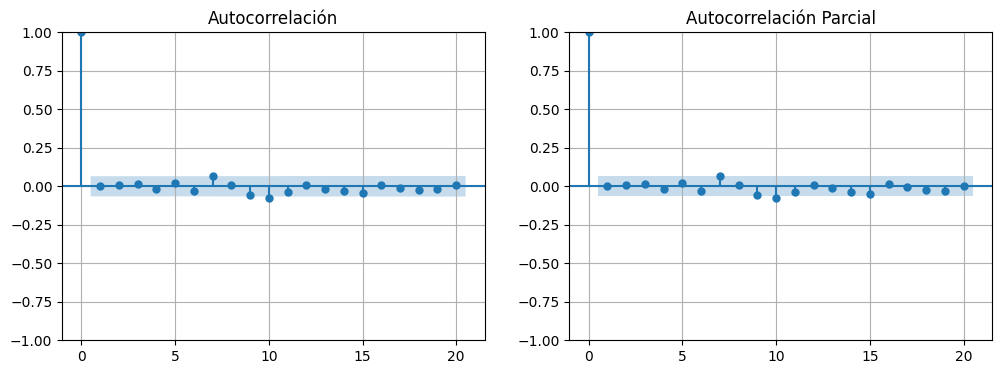

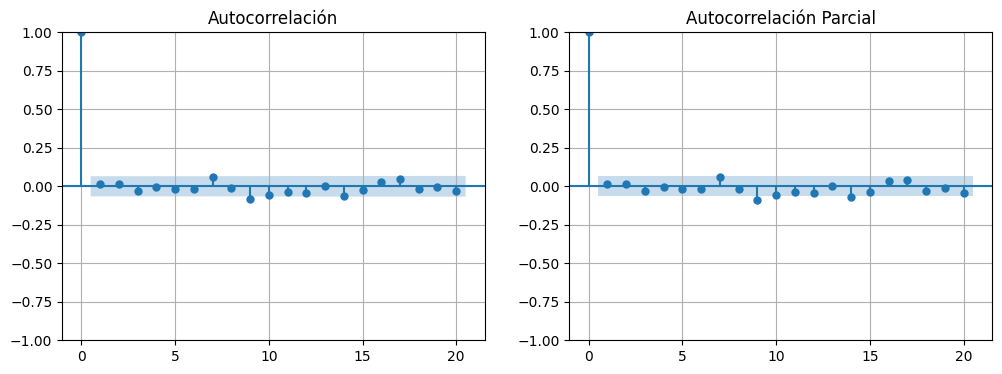

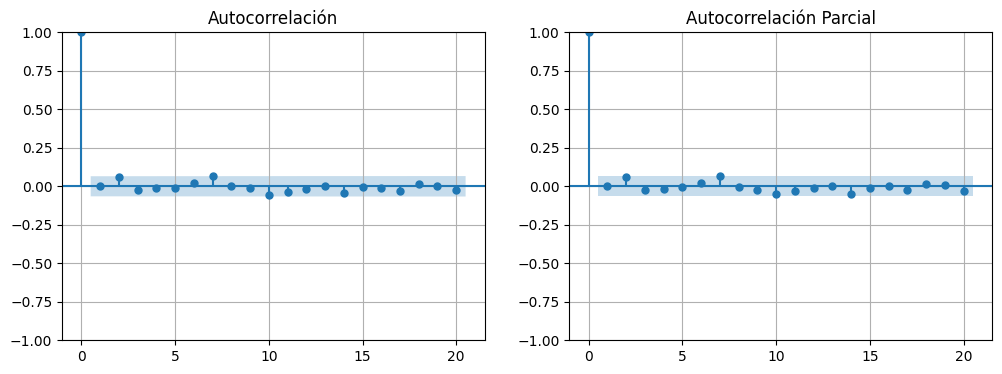

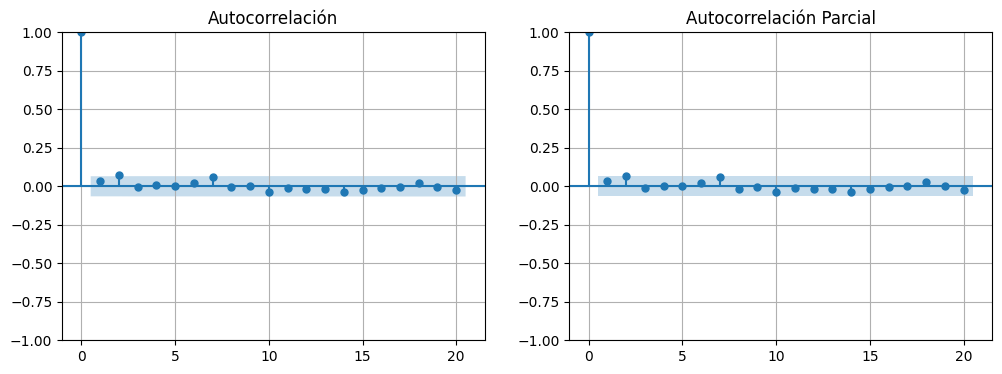

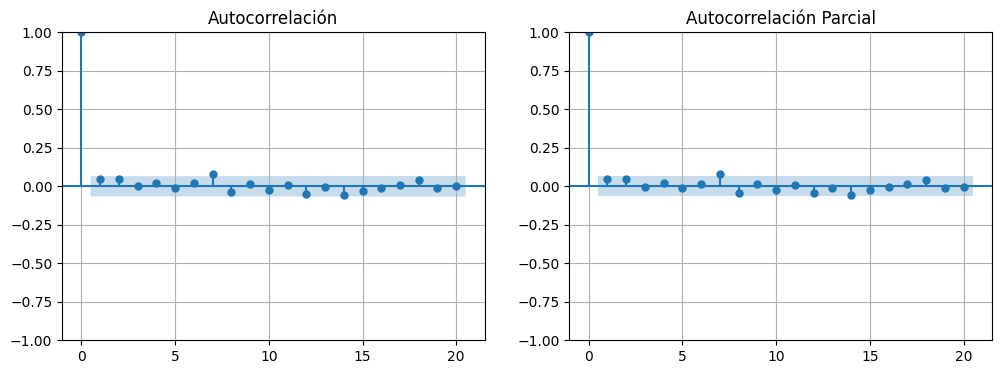

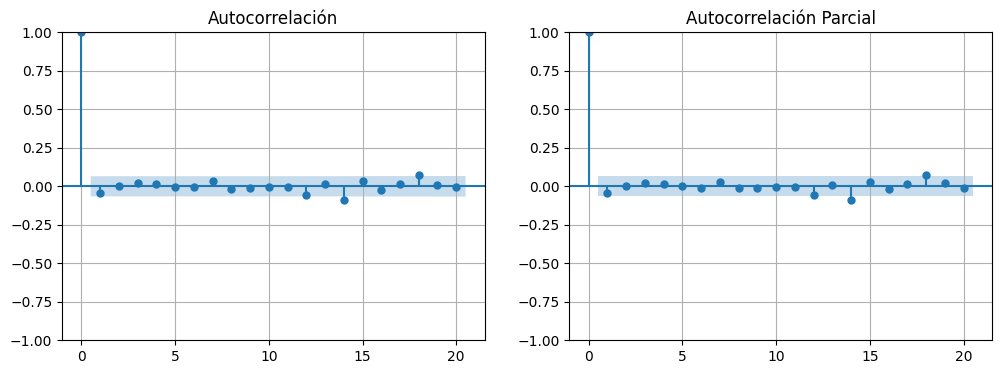

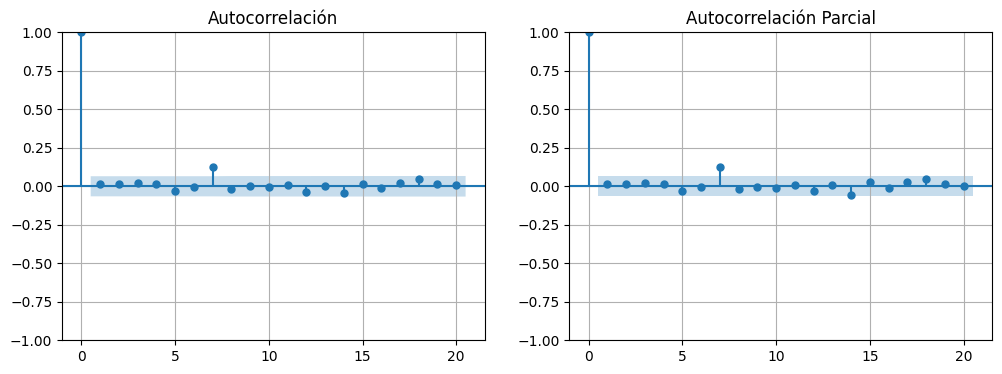

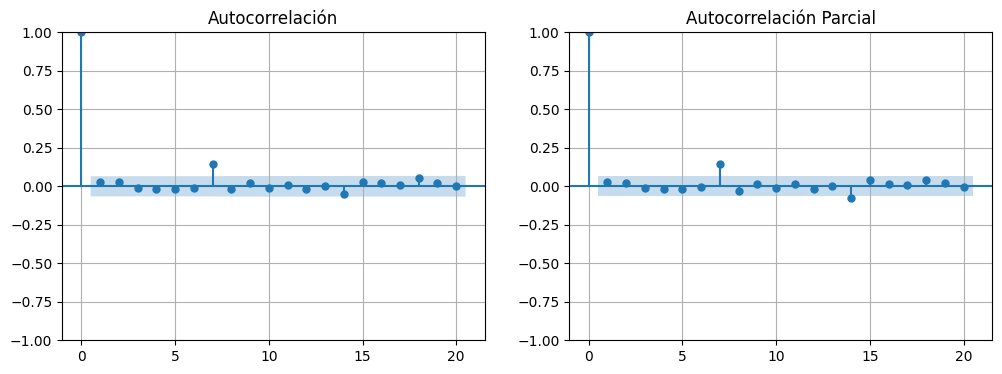

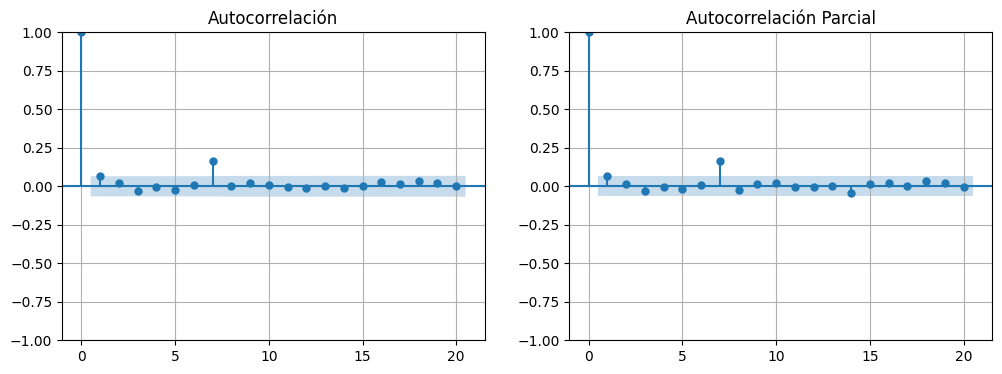

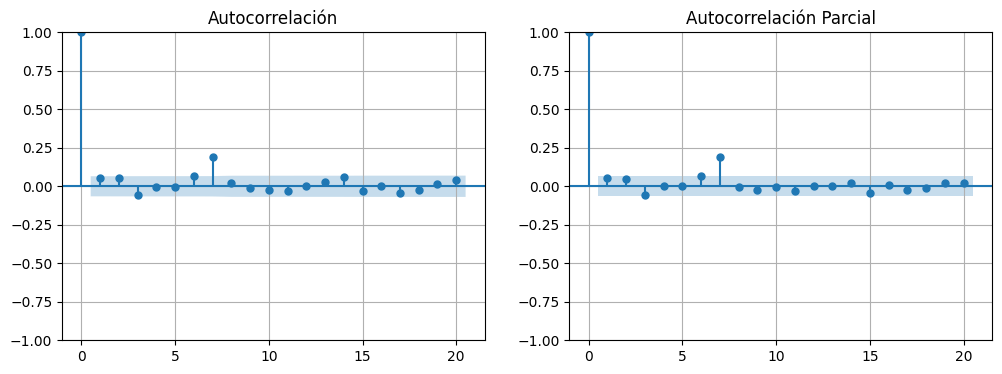

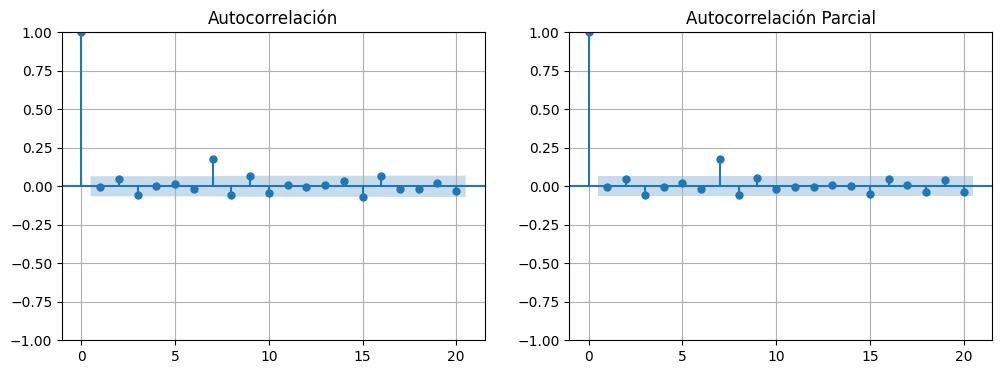

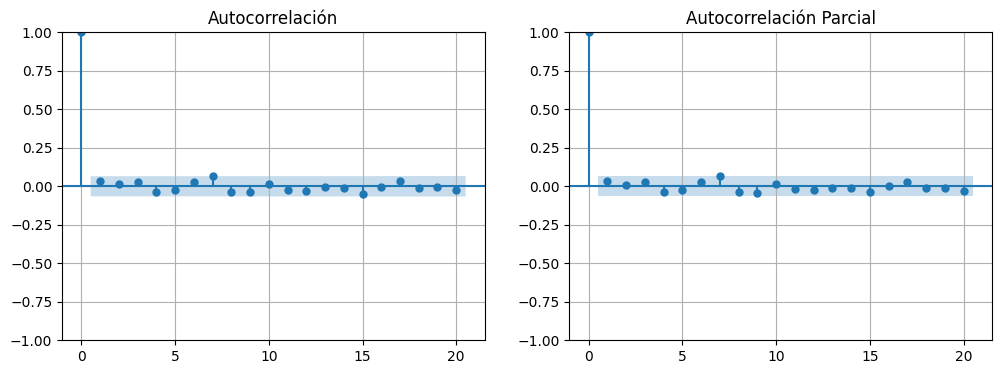

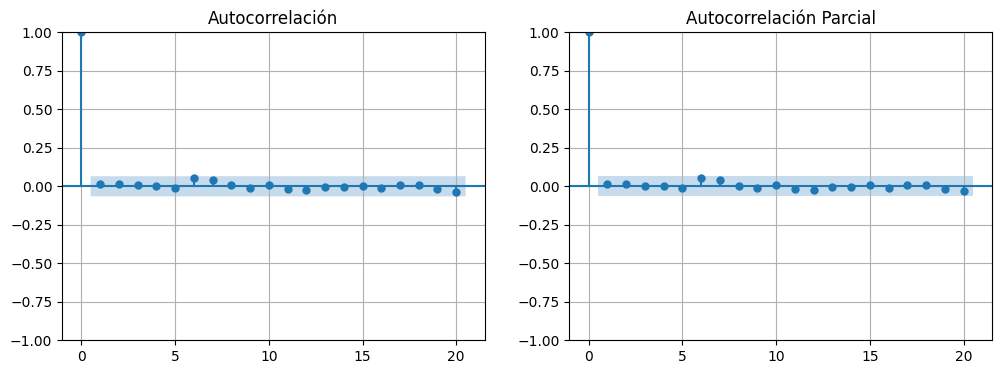

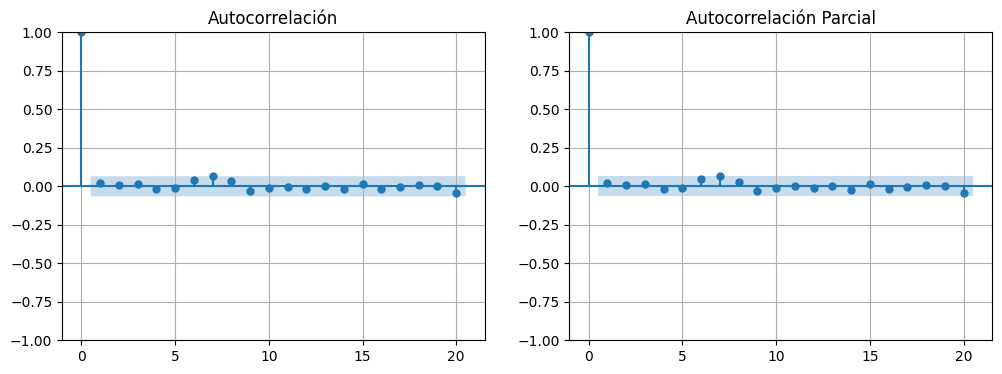

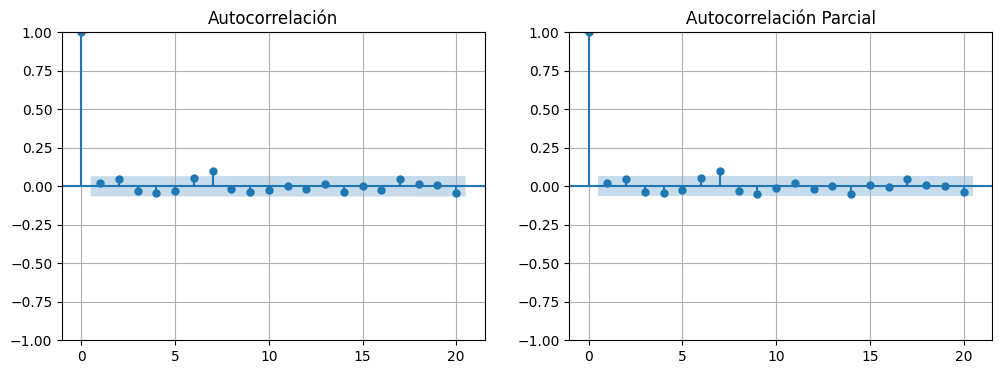

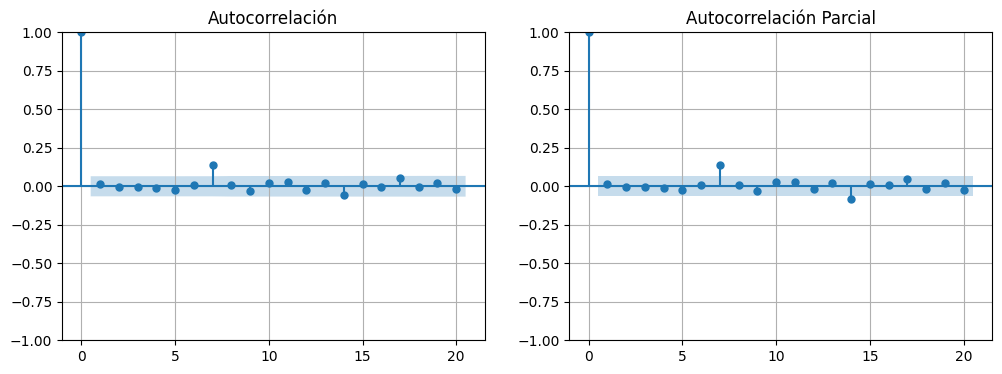

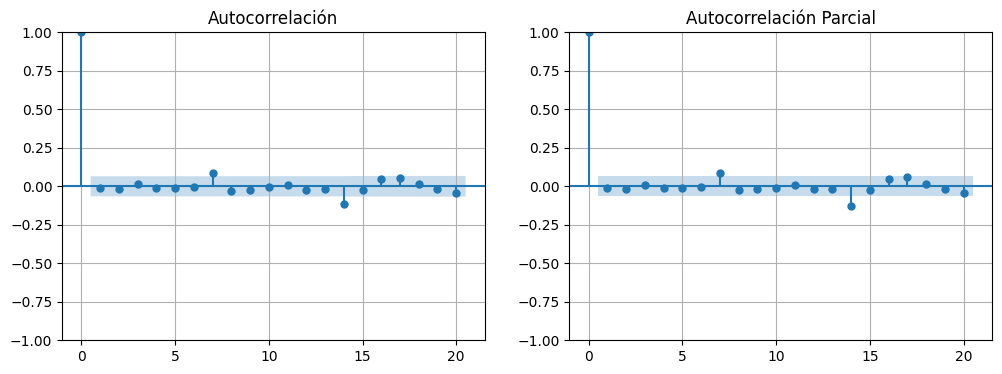

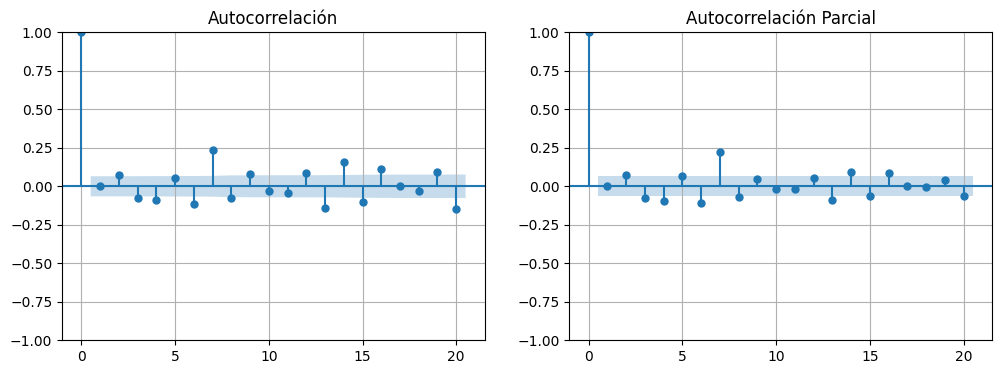

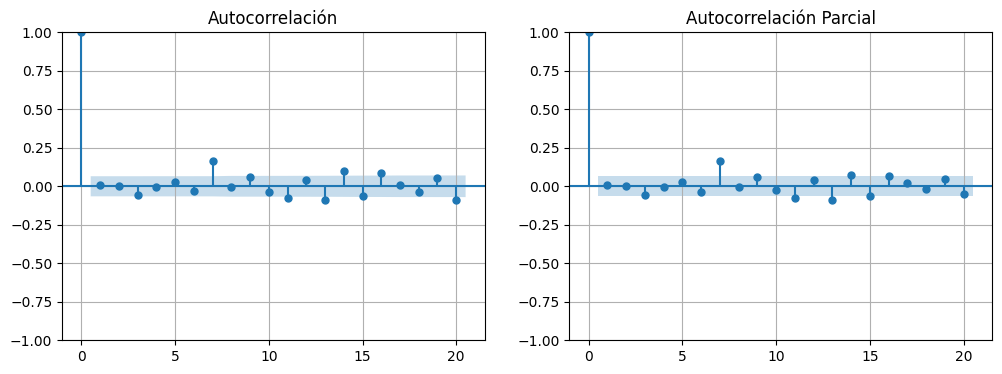

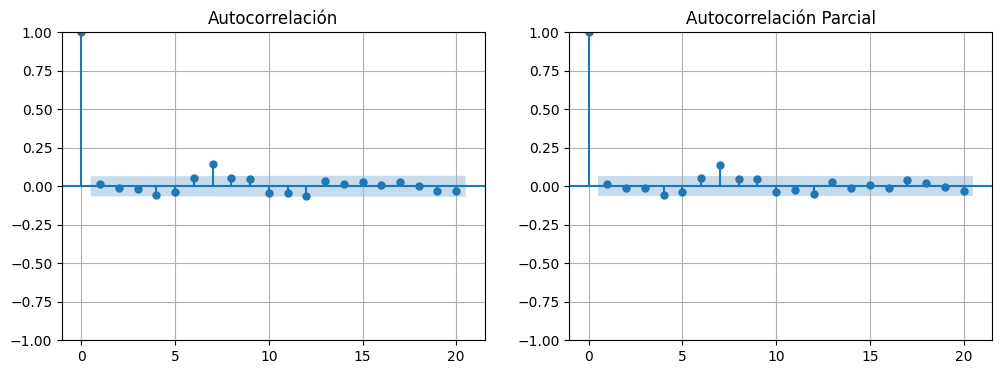

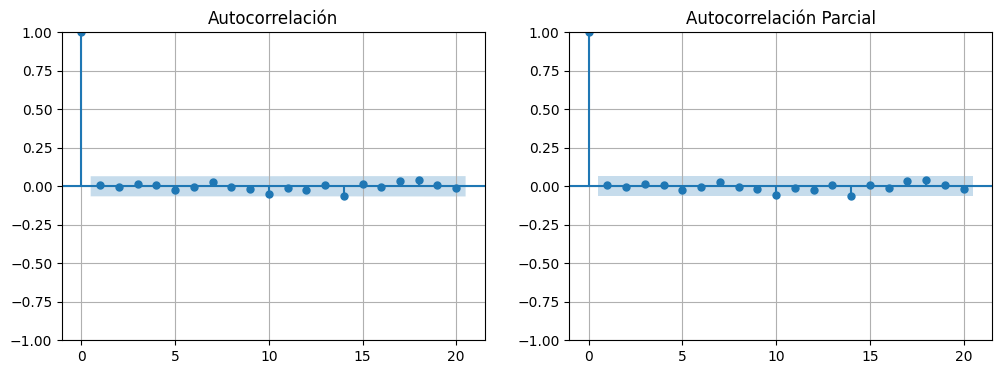

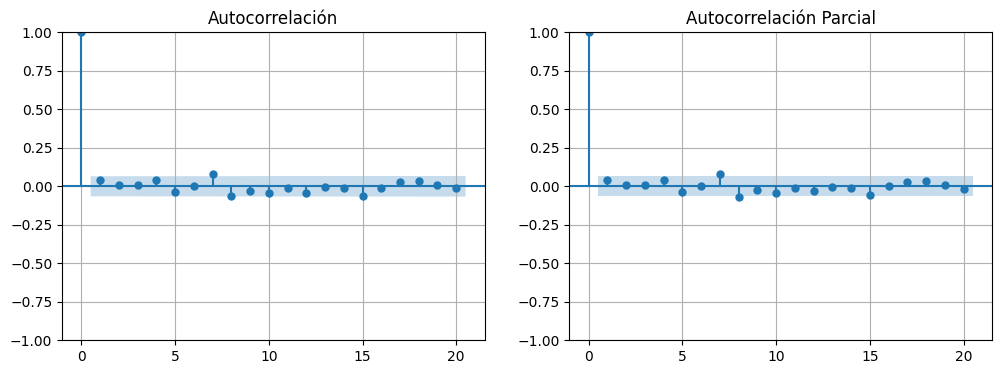

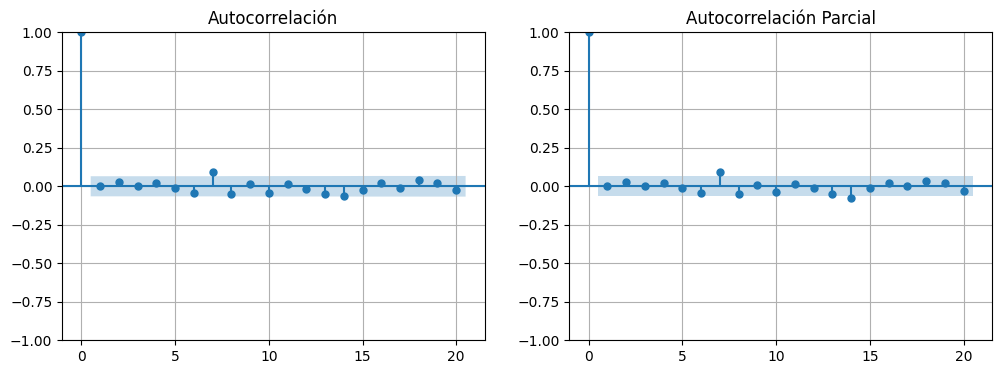

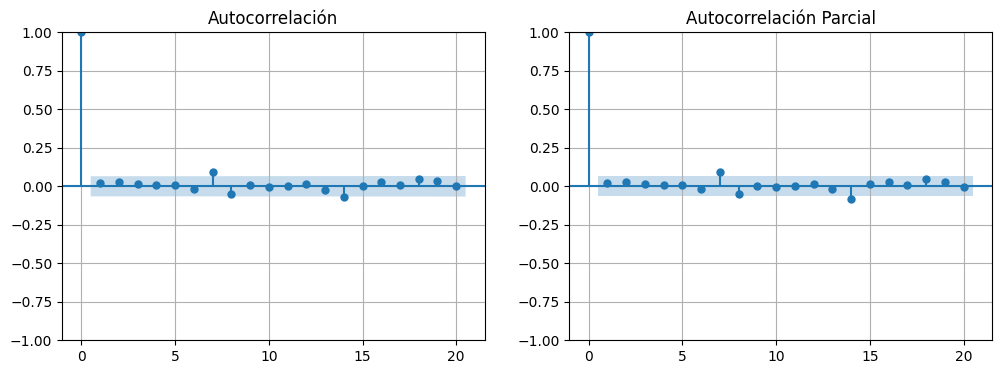

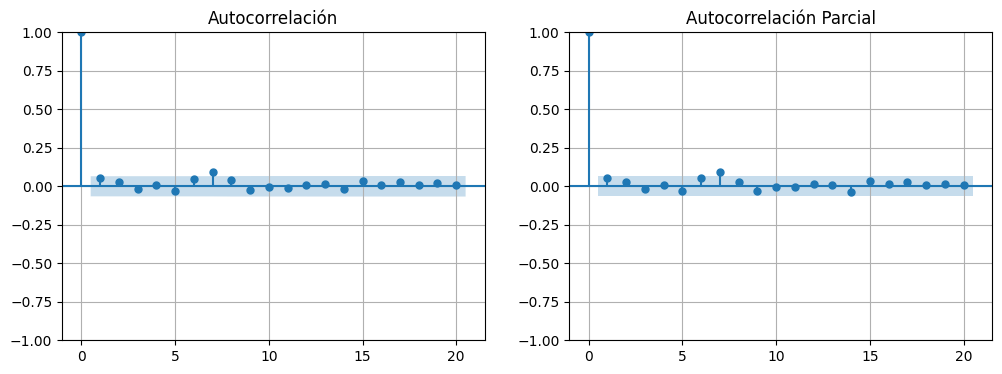

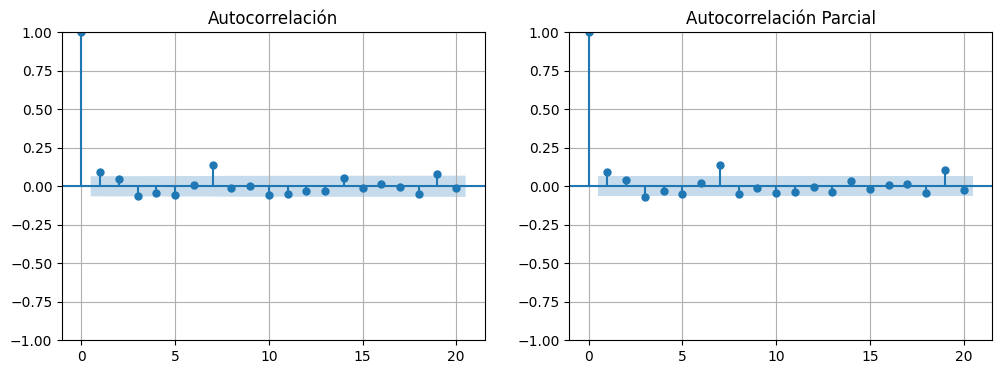

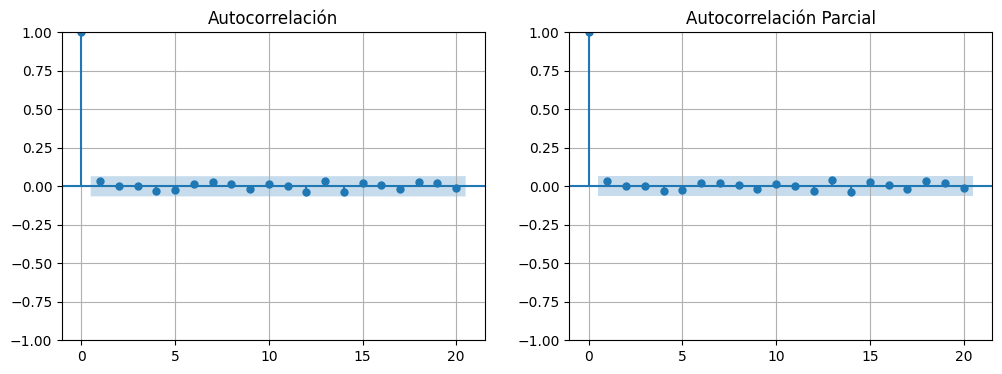

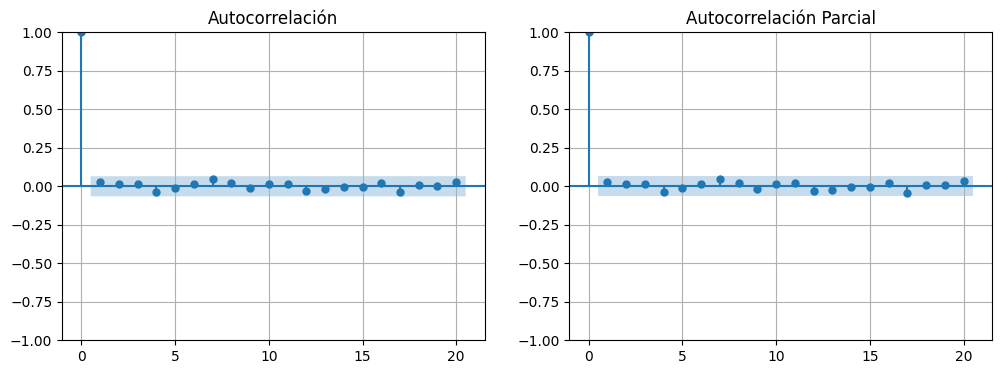

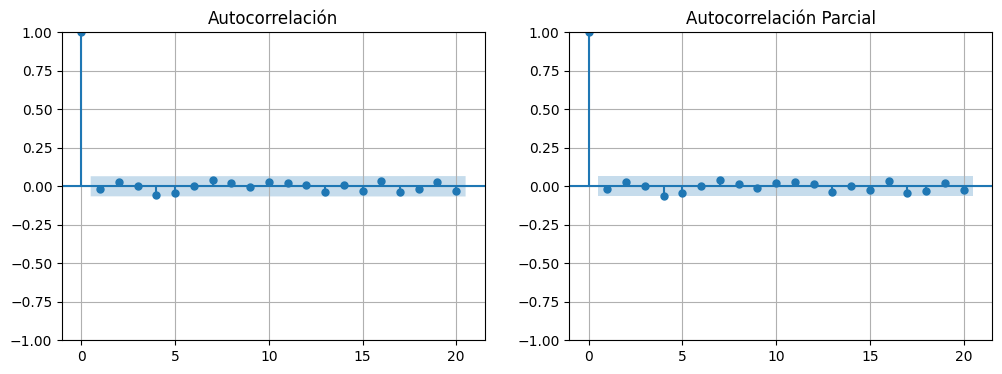

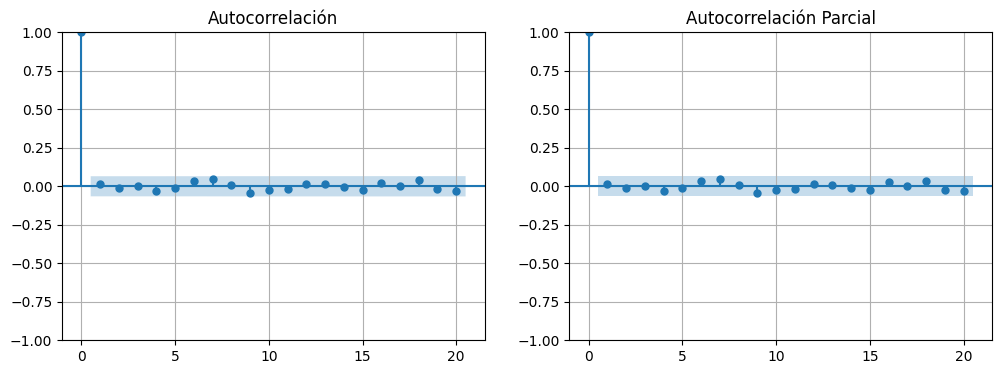

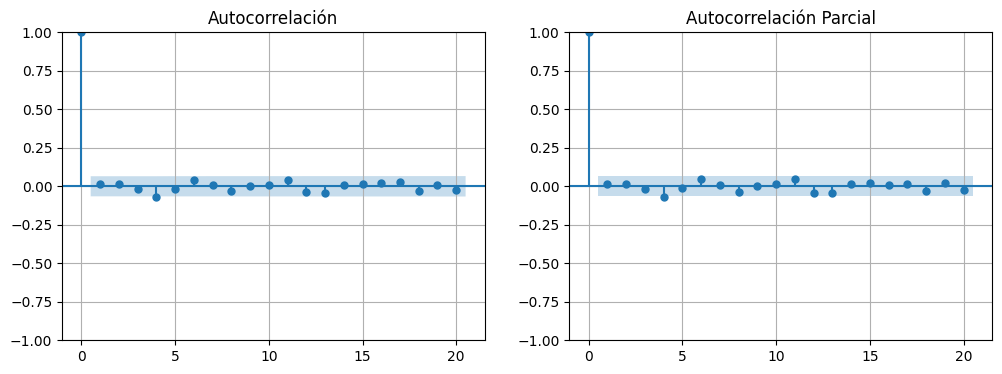

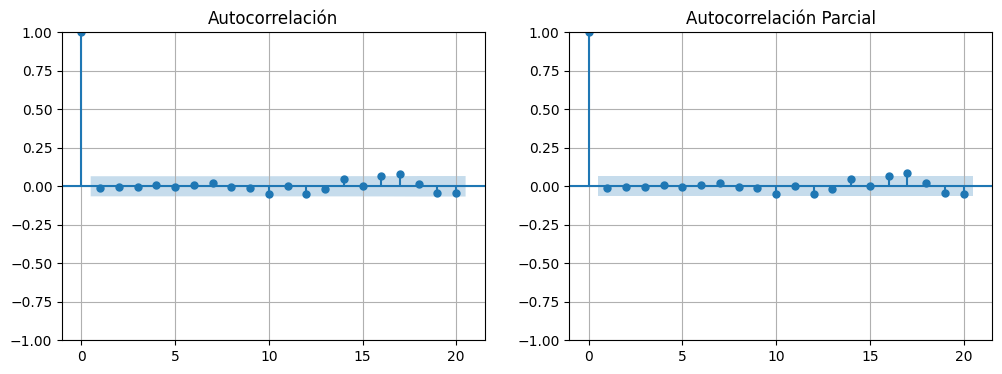

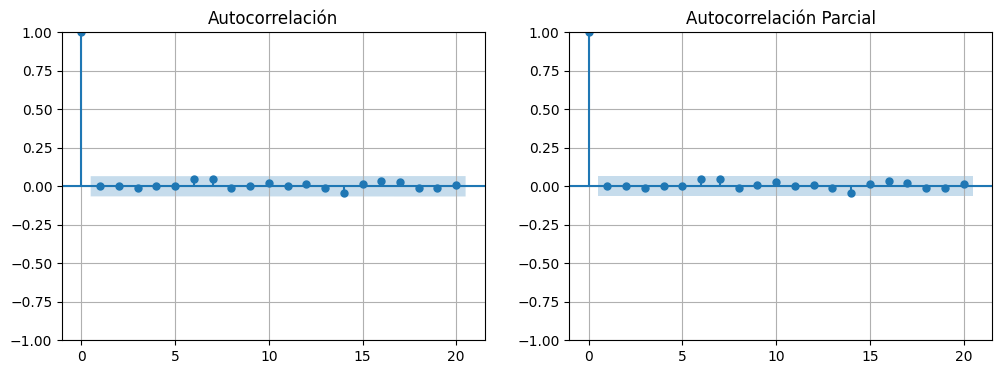

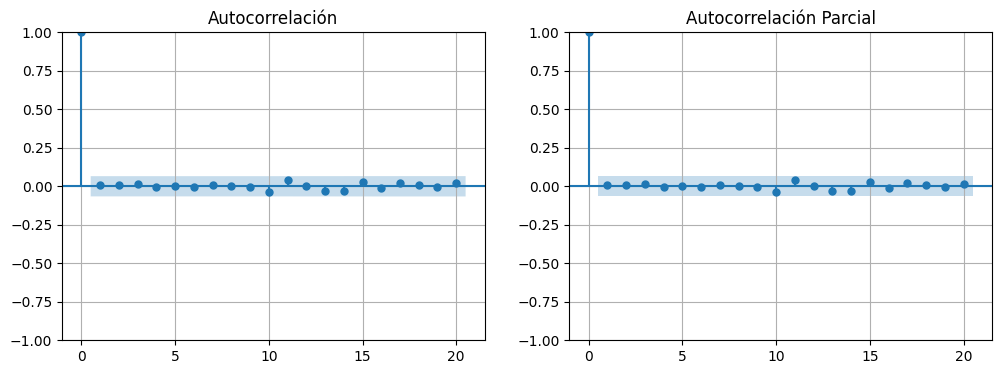

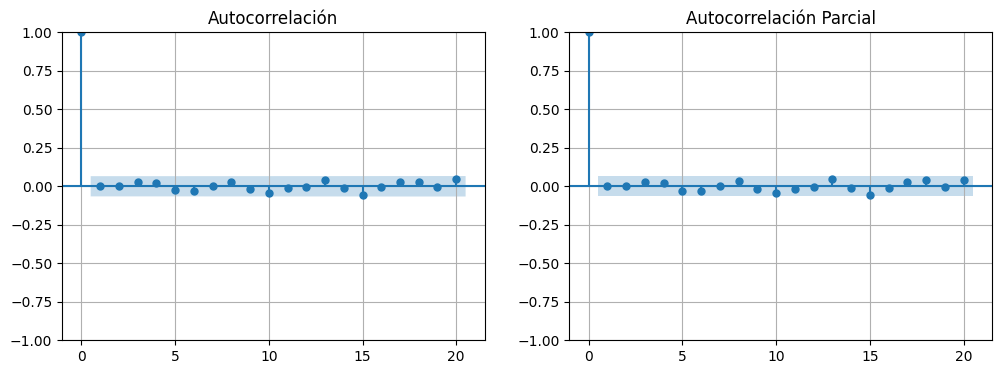

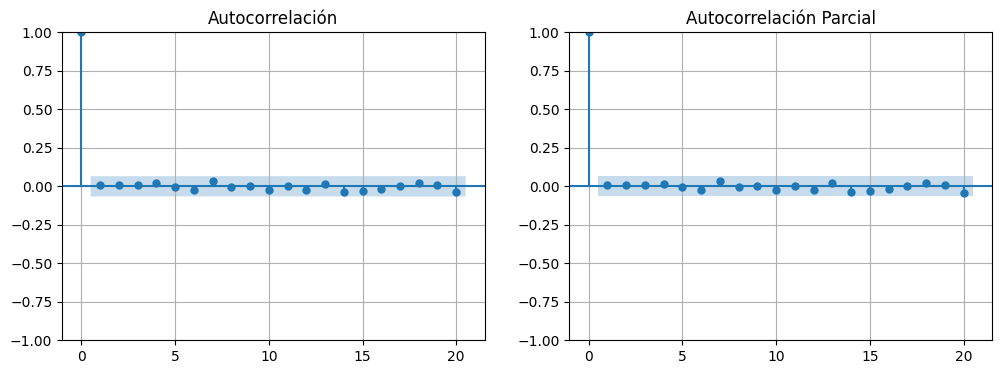

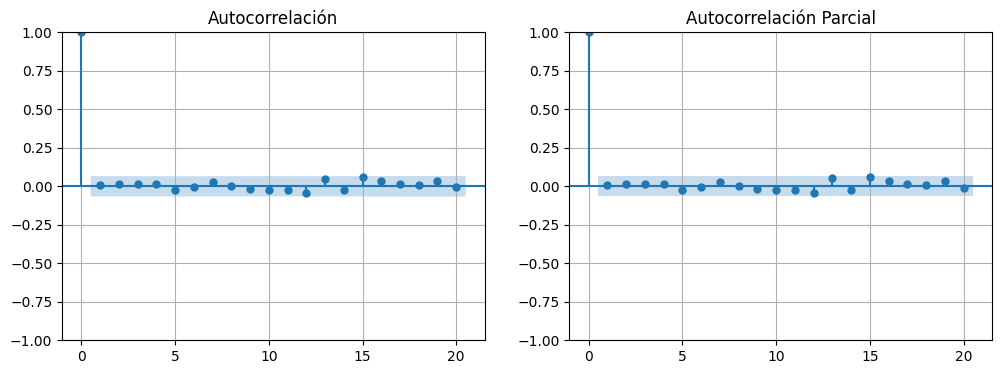

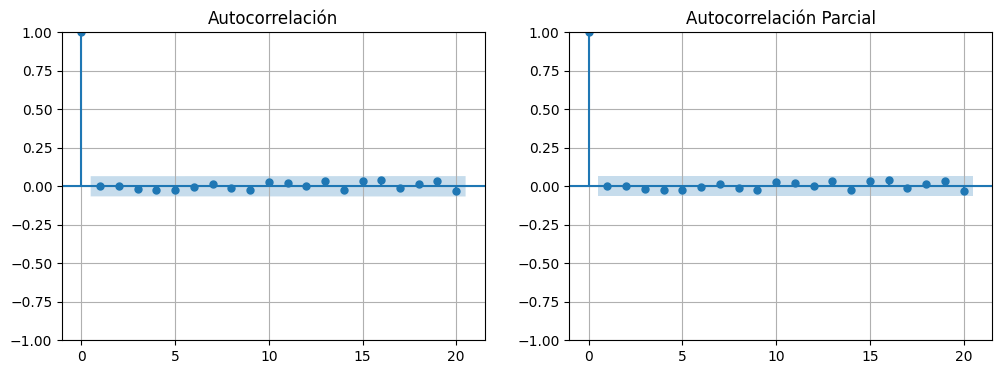

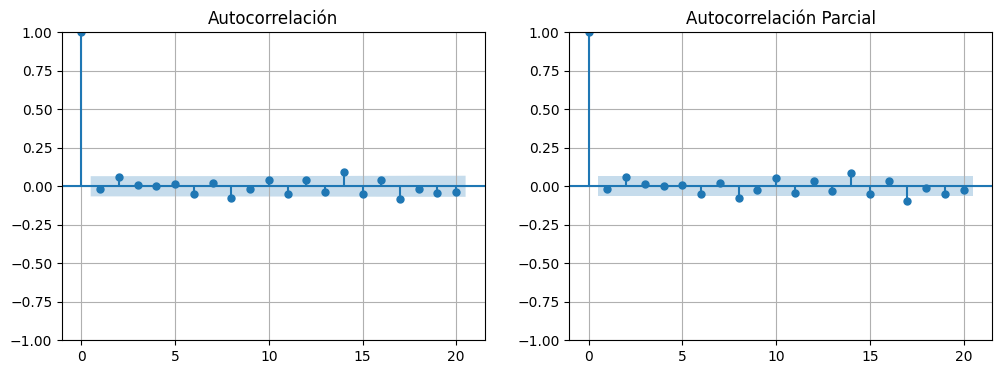

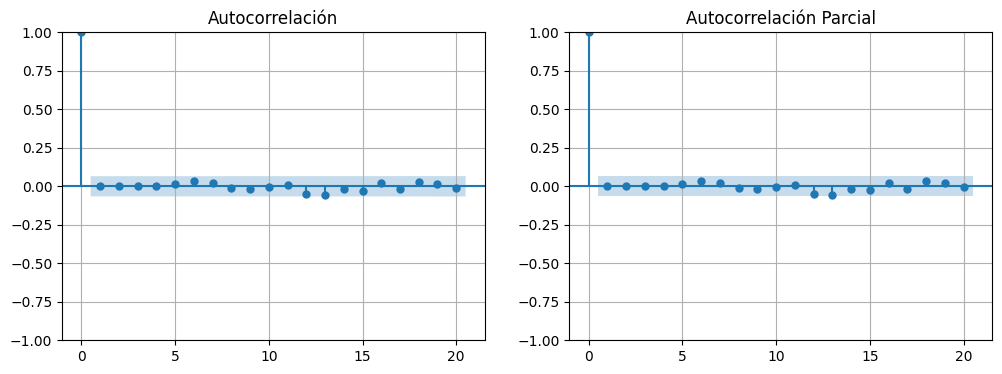

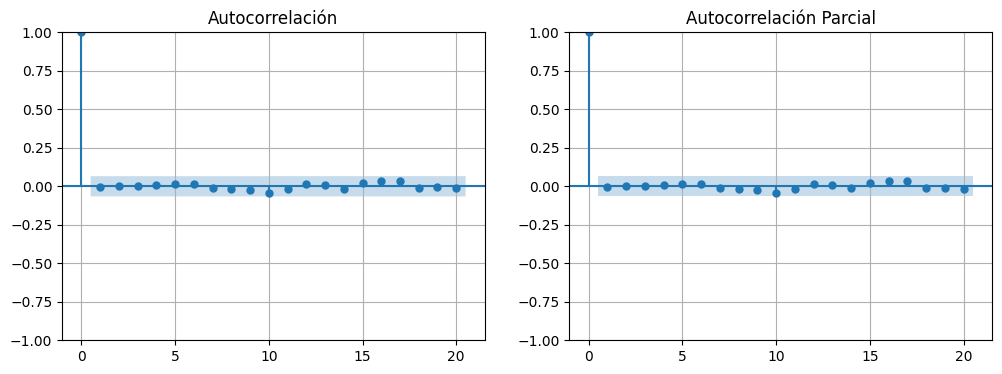

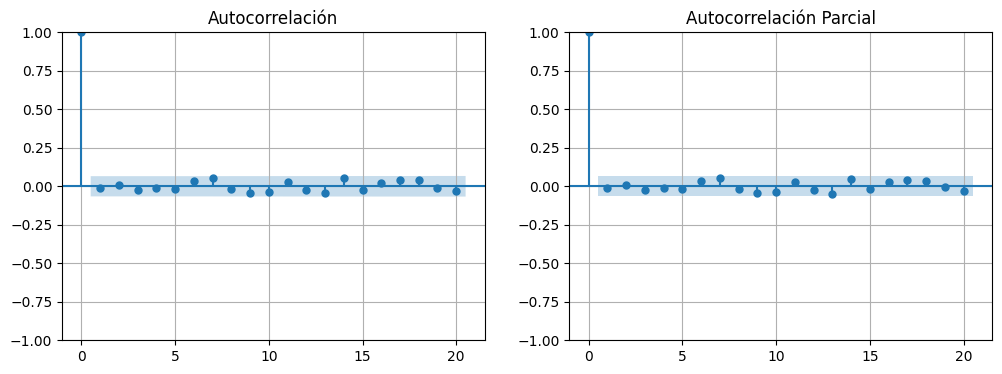

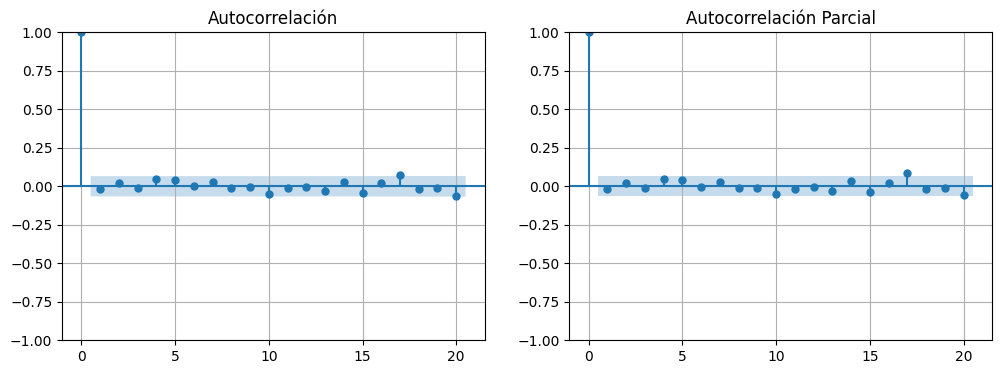

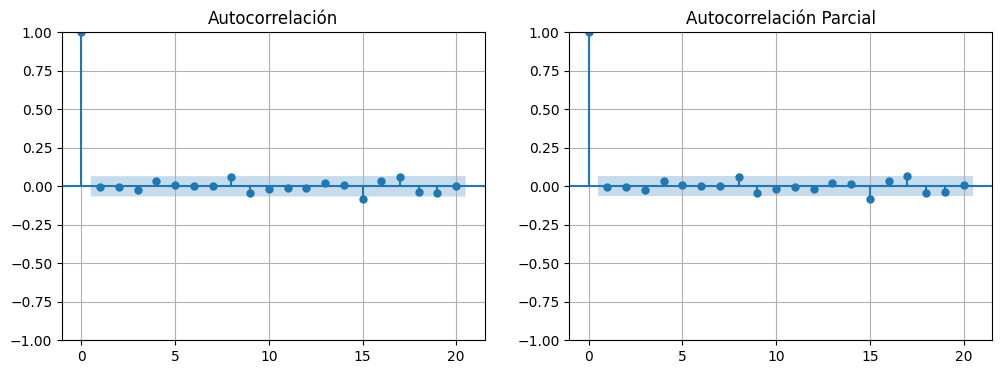

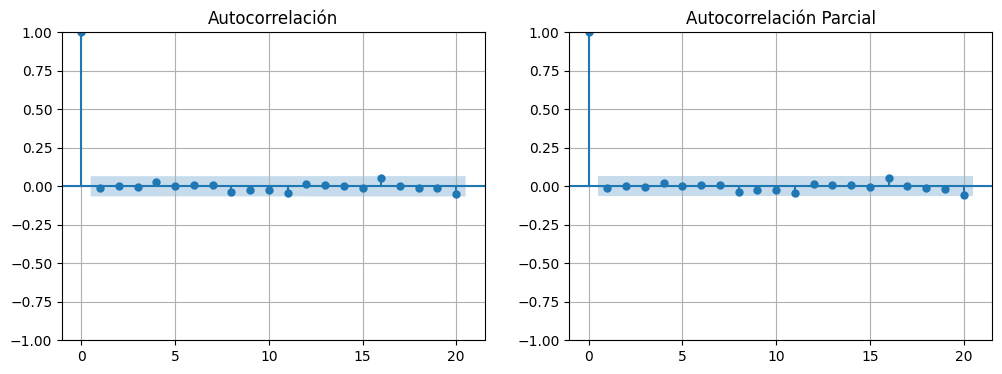

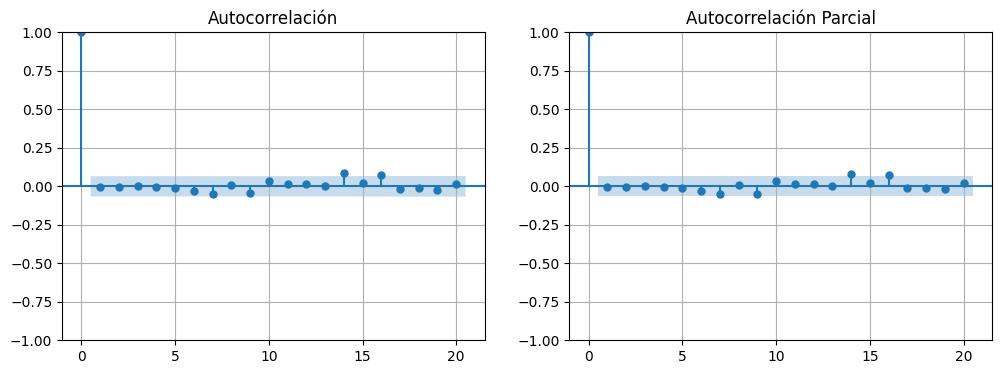

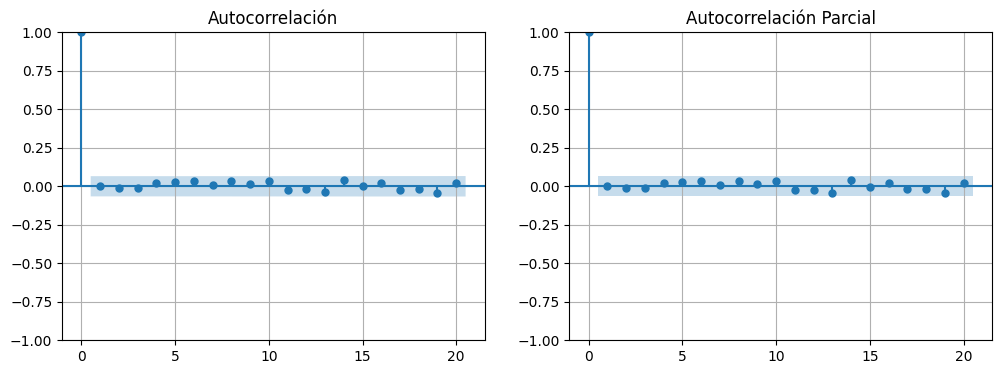

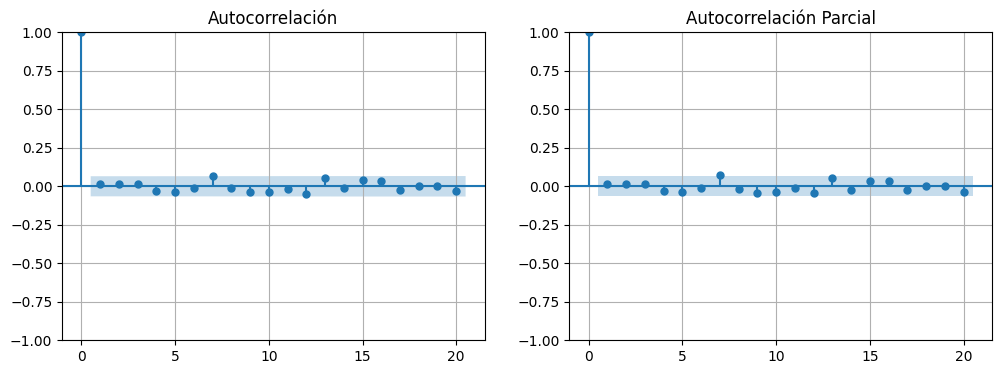

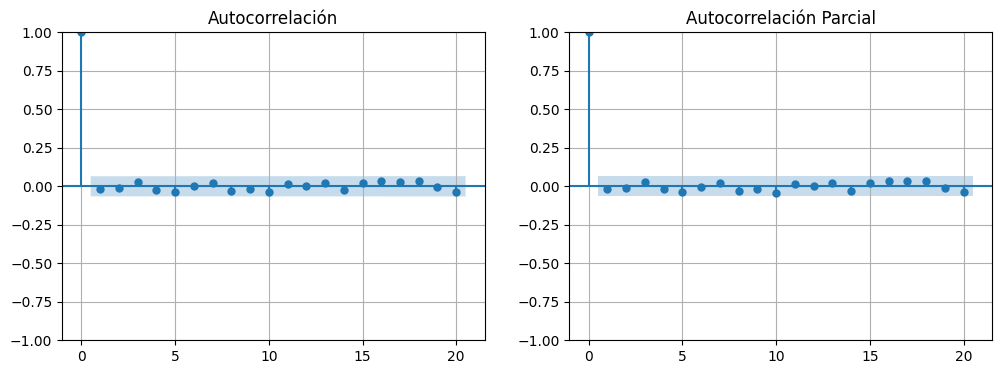

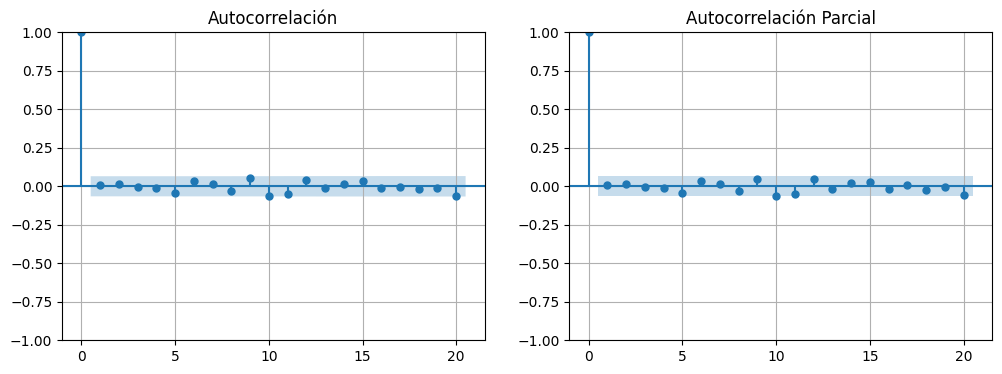

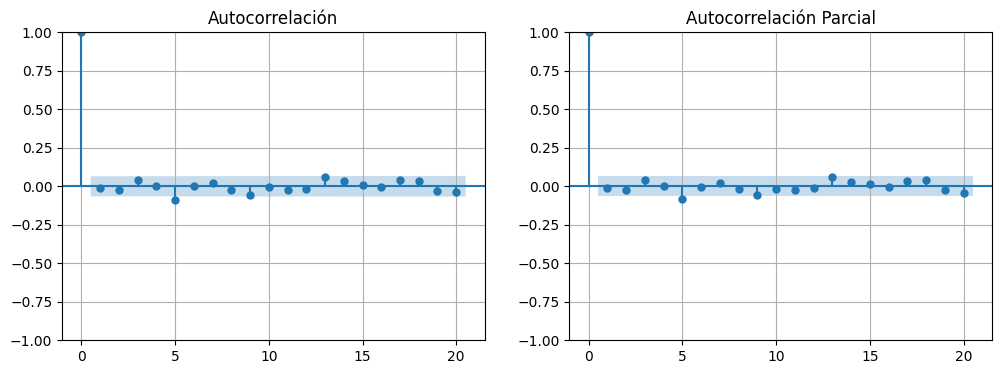

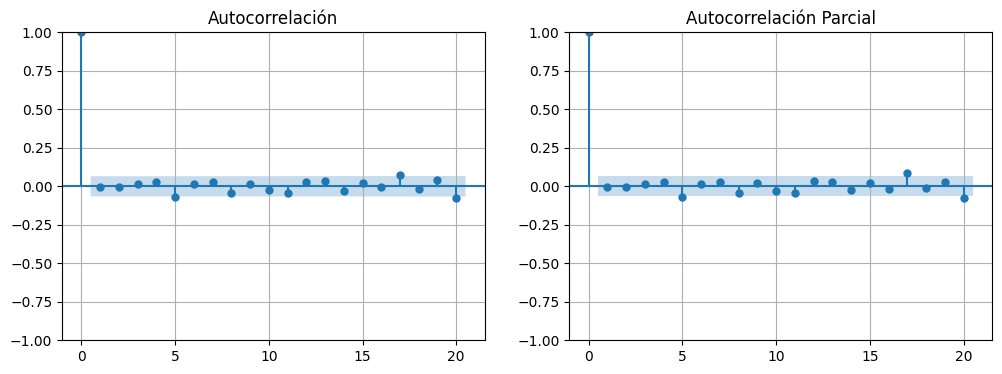

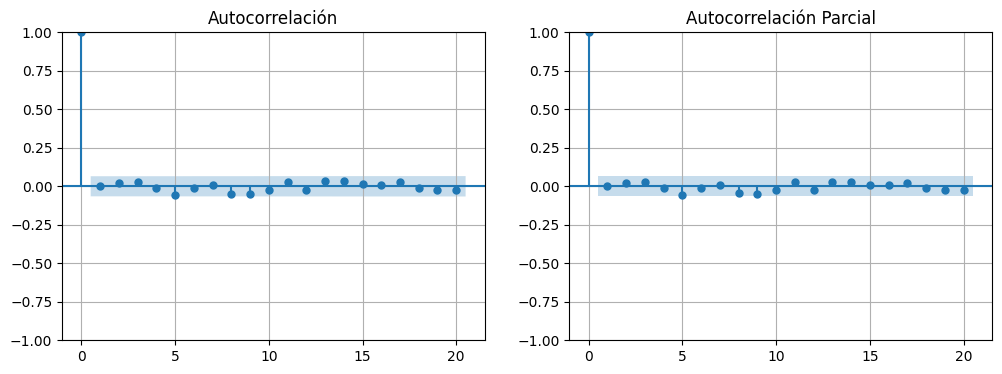

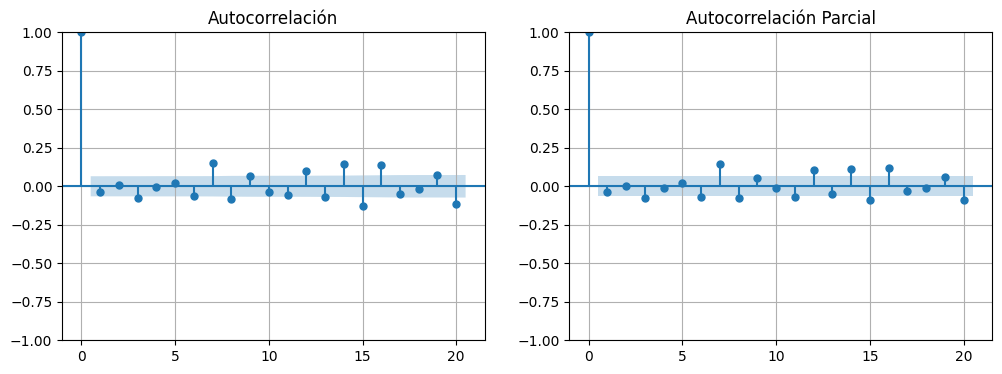

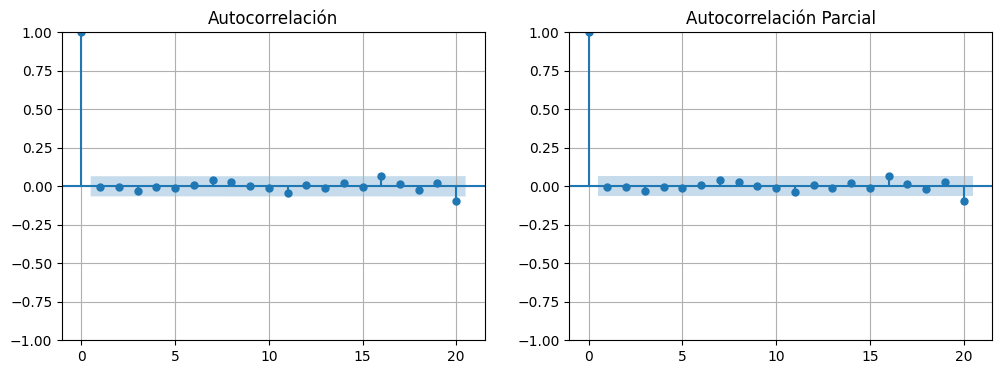

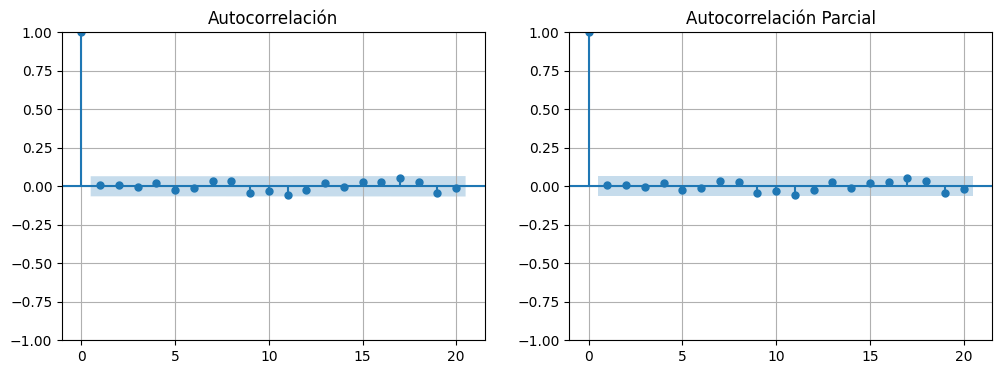

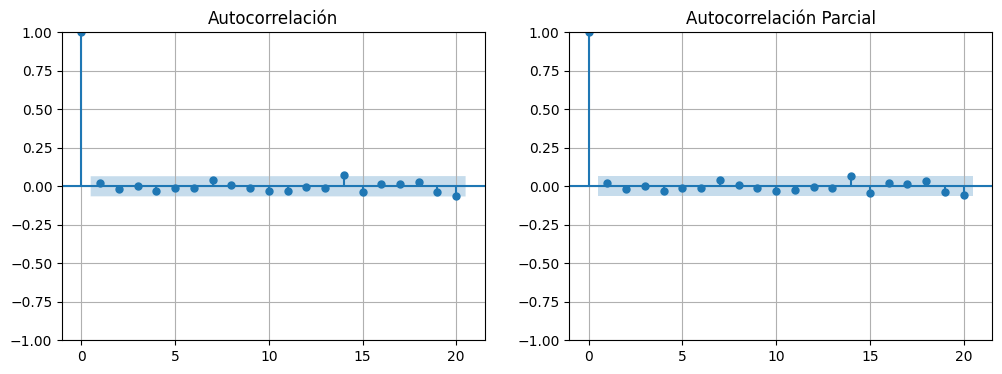

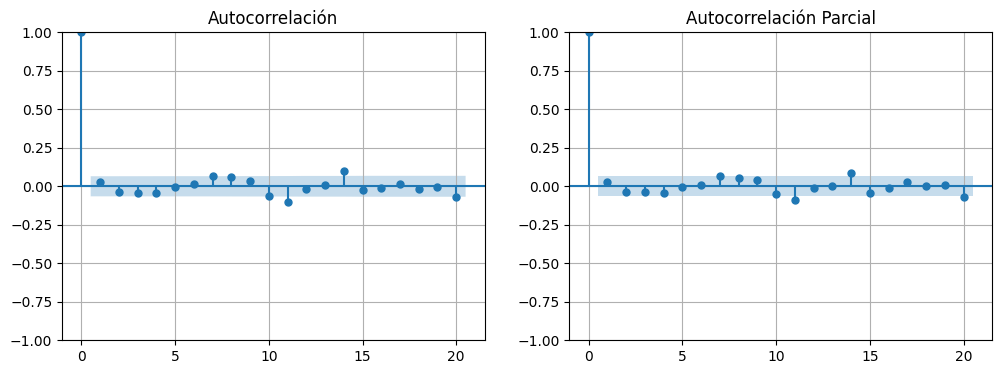

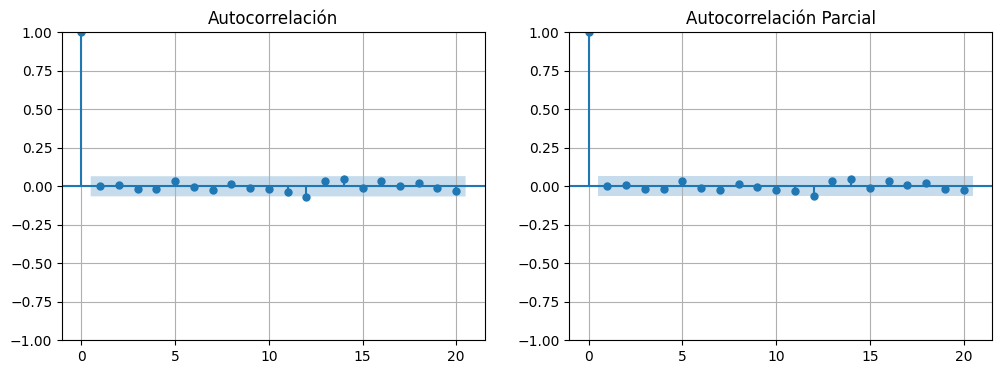

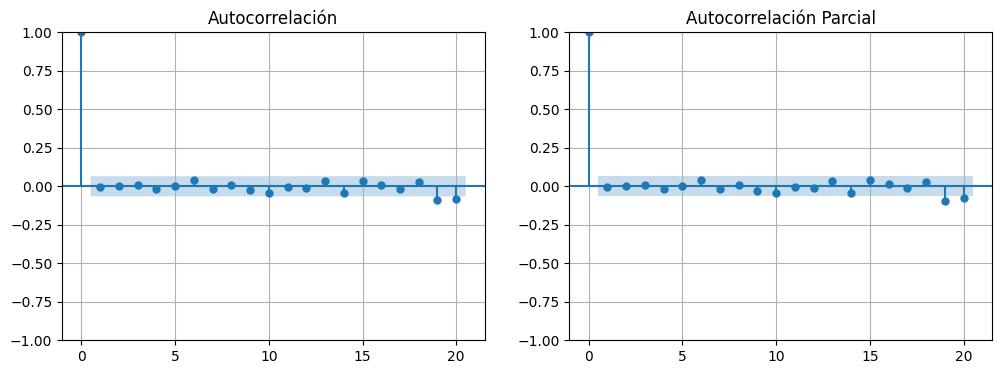

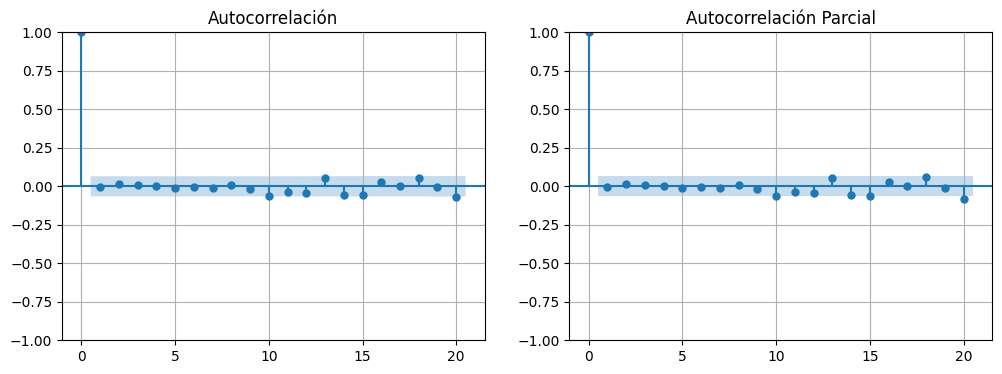

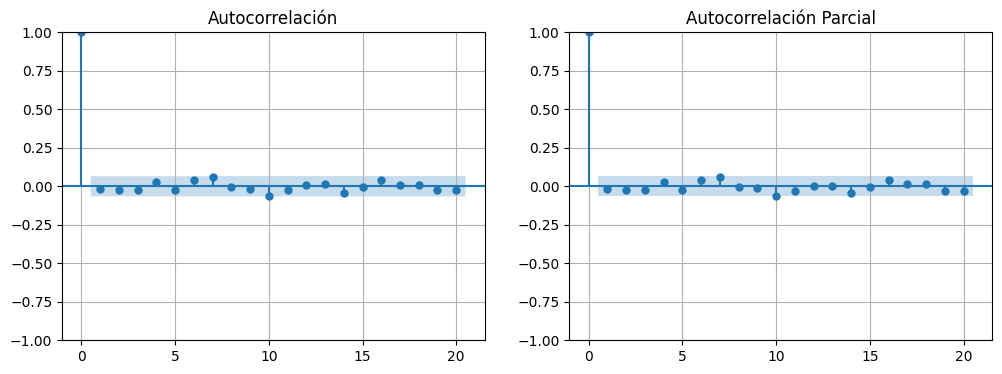

In [ ]:
class ARIMAModel:
    def __init__(self, df, linea=None, hora=None, fecha_columna='fecha', valor_columna='afluencia', frecuencia='D'):
        self.df = self.compactar_datos(df, linea, hora, fecha_columna, valor_columna, frecuencia)
        self.X = self.df[valor_columna]

    def compactar_datos(self, df, linea=None, hora=None, fecha_columna='fecha', valor_columna='afluencia', frecuencia='D'):
        """
        Función para compactar datos temporales en un DataFrame según una frecuencia específica.

        Parámetros:
        - df: pandas DataFrame
            DataFrame que contiene los datos a ser compactados.
        - linea: str o None, opcional
            Valor para filtrar el DataFrame por la columna 'Linea'. Si es None, no se aplica ningún filtro por línea.
        - hora: int o None, opcional
            Valor para filtrar el DataFrame por la columna 'Horas'. Si es None, no se aplica ningún filtro por hora.
        - fecha_columna: str, opcional (por defecto: 'fecha')
            Nombre de la columna que contiene las fechas en el DataFrame.
        - valor_columna: str, opcional (por defecto: 'afluencia')
            Nombre de la columna que contiene los valores a sumar durante la compactación.
        - frecuencia: str, opcional (por defecto: 'D')
            Frecuencia a la cual compactar los datos. Utiliza códigos de frecuencia de pandas (por ejemplo, 'D' para días, 'H' para horas).

        Salida:
        - pandas DataFrame
            DataFrame compactado con las sumas de los valores de 'valor_columna' según la frecuencia especificada.

        Notas:
        - La función realiza una copia del DataFrame original para evitar modificaciones no deseadas.
        - Se pueden proporcionar valores para 'linea' y 'hora' para filtrar los datos antes de la compactación.
        - La columna de fechas ('fecha_columna') debe estar en formato datetime para realizar la compactación correctamente.
        - La frecuencia determina el intervalo temporal para la compactación (por ejemplo, 'D' para días, 'H' para horas).
        """
        df_copy = df.copy()

        # Filtrar por línea y hora si se proporcionan
        if linea is not None:
            df_copy = df_copy[df_copy['Linea'] == linea]
        if hora is not None:
            df_copy = df_copy[df_copy['Horas'] == hora]

        df_copy[fecha_columna] = pd.to_datetime(df_copy[fecha_columna])
        df_copy.set_index(fecha_columna, inplace=True)

        # Compactar los datos utilizando la frecuencia especificada
        df_compactado = df_copy.groupby(['Linea', 'Horas', pd.Grouper(freq=frecuencia)]).sum().reset_index()

        return df_compactado

    def test_stationarity(self):
        """ Realizar la prueba de Dickey-Fuller """
        result = adfuller(self.X)
        print('Prueba de Dickey-Fuller:')
        print(f'Estadística de prueba: {result[0]}')
        print(f'P-valor: {result[1]}')
        print(f'Valores críticos: {result[4]}')
        return result[1]

    def train_arima_model(self):
        """
        Entrena un modelo ARIMA utilizando la librería statsmodels.
        ARIMA(p, d, q).

        Parámetros:
        - data: Serie temporal a modelar.
        - p: Orden del componente autorregresivo.
        - d: Orden de diferenciación para hacer estacionaria la serie temporal.
        - q: Orden del componente de media móvil.


        El AIC (Akaike Information Criterion) es un criterio de información que se utiliza para comparar
        modelos estadísticos. Fue propuesto por Hirotugu Akaike y se utiliza comúnmente en el contexto de
        la selección de modelos, especialmente en el campo de la estadística y el análisis de series temporales.
        La idea detrás del AIC es encontrar un equilibrio entre la complejidad del modelo y su capacidad para
        explicar los datos. Cuanto menor sea el valor del AIC, mejor se considera el modelo
        en términos de ajuste y complejidad.

        Retorna:
        - Modelo ARIMA ajustado.
        """
        # Train Test Split (si es necesario)
        train_size = int(len(self.X) * 0.99)
        self.train_data, self.test_data = self.X[:train_size], self.X[train_size:]

        # Definir rangos para p, d, q
        p_range = range(6, 9)
        d_range = range(0, 2)
        q_range = range(6, 9)

        # Generar todas las combinaciones posibles de p, d, q
        order_combinations = list(itertools.product(p_range, d_range, q_range))

        best_aic = float('inf')  # Inicializar con un valor grande
        best_order = None

        # Iterar sobre todas las combinaciones y ajustar modelos ARIMA
        for order in order_combinations:
            try:
                arima_model = ARIMA(self.train_data, order=order, enforce_stationarity=False, enforce_invertibility=False)
                arima_model_fit = arima_model.fit()
                current_aic = arima_model_fit.aic

                if current_aic < best_aic:
                    best_aic = current_aic
                    best_order = order
            except ValueError as e:
                print(f'Error ajustando modelo ARIMA para orden {order}: {e}')
                continue

        # Ajustar el mejor modelo ARIMA con los órdenes encontrados
        try:
            best_arima_model = ARIMA(self.train_data, order=best_order)
            best_arima_model_fit = best_arima_model.fit()

            # Imprimir los órdenes óptimos y el AIC asociado
            print(f'Mejores órdenes: {best_order}')
            print(f'Mejor AIC: {best_aic}')

            # Visualizar autocorrelación y autocorrelación parcial del residuo
            self.plot_acf_pacf(best_arima_model_fit.resid)

            return best_arima_model_fit, best_aic, best_order
        except ValueError as e:
            print(f'Error ajustando el mejor modelo ARIMA: {e}')
            return None

    def plot_acf_pacf(self, resid):
        """
        Función para visualizar los gráficos de autocorrelación (ACF) y autocorrelación parcial (PACF) de los residuos.

        Parámetros:
        - resid: array-like
            Una serie de tiempo de residuos para la cual se desea visualizar los gráficos.

        Salida:
        - Figura de los gráficos ACF y PACF de los residuos.
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        # Autocorrelación
        plot_acf(resid, lags=20, ax=ax1)
        ax1.set_title('Autocorrelación')
        ax1.grid(True)
        # Autocorrelación parcial
        plot_pacf(resid, lags=20, ax=ax2)
        ax2.set_title('Autocorrelación Parcial')
        ax2.grid(True)
        return fig

    def apply_arima_to_test(self, model_fit):
        """
        Aplica un modelo ARIMA previamente ajustado a los datos de prueba y devuelve las predicciones.

        Parámetros:
        - model_fit: Modelo ARIMA previamente ajustado.

        Retorna:
        - Predicciones del modelo ARIMA en los datos de prueba.
        """
        if model_fit is None:
            print("No se proporcionó un modelo ARIMA válido.")
            return None

        # Aplicar el modelo a los datos de prueba
        predictions = model_fit.forecast(steps=len(self.test_data))

        return predictions

    def plot_predictions_vs_actual(self, predictions):
        """
        Visualiza la comparación entre los datos reales y las predicciones del modelo.

        Parámetros:
        - predictions: Predicciones del modelo ARIMA en los datos de prueba.
        - test_data: Datos reales de prueba.

        Salida:
        - Figura del gráfico de comparación entre Datos Reales y Predichos.
        """
        # Crear un DataFrame para visualización
        df_vis = pd.DataFrame({'Actual': self.test_data, 'Predicted': predictions}, index=self.test_data.index)

        # Graficar los datos reales y las predicciones
        fig = plt.figure(figsize=(13, 4))
        plt.plot(df_vis['Actual'], label='Actual', marker='o')
        plt.plot(df_vis['Predicted'], label='Predicted', marker='o')
        plt.title('Comparación entre Datos Reales y Predichos')
        plt.xlabel('Fecha')
        plt.ylabel('Valor')
        plt.legend()
        plt.grid(True)
        return fig

    def score(self, predictions):
      # Calcular R²
      r2 = r2_score(self.test_data, predictions)
      print(f"Coeficiente de determinación (R²): {r2}")
      # Calcular MSE
      mse = mean_squared_error(self.test_data, predictions)
      print(f"Error cuadrático medio (RMSE): {np.sqrt(mse)}")
      return r2, np.sqrt(mse)

# Nombre de la carpeta de salida
output_folder = "output_data"

# Crear la carpeta de salida si no existe
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for linea in df.loc[~df.Linea.isin(['T-A', 'M', 'J', 'K']),'Linea'].unique():
    eval_linea = {}  # Nuevo diccionario para cada línea

    # Crear la carpeta para la línea si no existe
    line_folder = os.path.join(output_folder, str(linea))
    if not os.path.exists(line_folder):
        os.makedirs(line_folder)

    for i in range(8, 23):
        print(f"Linea: {linea} - Hora: {i}")
        print("=" * 100)
        try:
            arima_model_instance = ARIMAModel(df, linea=linea, hora=i, fecha_columna='Fecha', valor_columna='Qty_passangers', frecuencia='D')
            pvalue = arima_model_instance.test_stationarity()
            model_fit, best_aic, best_order = arima_model_instance.train_arima_model()
            predictions = arima_model_instance.apply_arima_to_test(model_fit)

            # Guardar la imagen generada por plot_predictions_vs_actual
            fig_pred_vs_actual = arima_model_instance.plot_predictions_vs_actual(predictions)
            image_filename_pred_vs_actual = os.path.join(line_folder, f"{linea}_{i}_prediction_vs_actual_plot.png")
            fig_pred_vs_actual.savefig(image_filename_pred_vs_actual)
            plt.close(fig_pred_vs_actual)

            # Guardar la imagen generada por plot_acf_pacf
            resid = model_fit.resid
            fig_acf_pacf = arima_model_instance.plot_acf_pacf(resid)
            image_filename_acf_pacf = os.path.join(line_folder, f"{linea}_{i}_acf_pacf_plot.png")
            fig_acf_pacf.savefig(image_filename_acf_pacf)
            plt.close(fig_acf_pacf)

            # Scores
            r2, mse = arima_model_instance.score(predictions)
            eval_linea[str(i)] = {'predictions': predictions.values.tolist(), 'scores': [r2, mse], 'p-value': pvalue, 'aic' : best_aic, 'best-order' : best_order}

        except Exception as e:
            print(f"Error para Linea {linea}, Hora {i}: {e}")

    # Guardar el JSON para cada línea
    json_filename = os.path.join(line_folder, f"{linea}_output.json")
    with open(json_filename, "w") as json_file:
        json.dump(eval_linea, json_file, indent=6)

# Guardar un punto zip en colab
---

In [ ]:
import shutil

# Ruta de la carpeta que deseas descargar
folder_path = '/content/output_data'

# Ruta de salida del archivo comprimido (zip)
output_path = '/content/output_data.zip'

# Crear el archivo comprimido
shutil.make_archive(output_path, 'zip', folder_path)

'/content/output_data.zip.zip'

# Un poco de teoria
---

# Interpretación de Residuales en Modelo ARIMA

## Autocorrelación (ACF) de Residuales:

1. **Residuales No Correlacionados:**
   - Si todos los lags están dentro de las bandas de confianza, indica que los residuales no muestran patrones significativos de autocorrelación.
   - Esto es deseable, ya que sugiere que el modelo ARIMA ha capturado bien la estructura de autocorrelación en los datos.

2. **Residuales Correlacionados:**
   - Si algunos lags están fuera de las bandas de confianza, podría indicar que hay patrones de autocorrelación residual que no se están capturando completamente.
   - Podría ser necesario ajustar el modelo ARIMA o considerar modelos más complejos.

## Autocorrelación Parcial (PACF) de Residuales:

1. **Sin Estructura Clara:**
   - Si todos los lags están dentro de las bandas de confianza, sugiere que no hay patrones evidentes de autocorrelación parcial en los residuales.
   - Esto es positivo, ya que indica que cualquier correlación significativa entre los residuales se ha explicado en el modelo.

2. **Estructura Residual:**
   - Si algunos lags están fuera de las bandas de confianza, podría indicar que hay patrones de autocorrelación parcial en los residuales que podrían ser modelados de manera más efectiva.

## Consideraciones Generales:

- **Patrones Estacionales o Cíclicos:**
  - Si ves patrones repetitivos en los lags que están fuera de las bandas de confianza, podría indicar la presencia de estacionalidad no capturada o patrones cíclicos en los residuales.

- **Necesidad de Ajuste Adicional:**
  - Si hay evidencia de autocorrelación significativa en los residuales, podrías necesitar ajustar el modelo ARIMA, considerar términos autorregresivos adicionales o explorar modelos más complejos.

Recuerda que la interpretación es un proceso iterativo, y ajustar el modelo según sea necesario puede mejorar la calidad de las predicciones. Es importante utilizar múltiples herramientas y pruebas estadísticas para evaluar la validez del modelo ARIMA y hacer ajustes según sea necesario.


# Almacenar Info
---

In [ ]:
# eval = {}
# for linea in df.loc[~df.Linea.isin(['T-A', 'M', 'J', 'K']),'Linea'].unique():
#   for i in range(8,23):
#     print(f"Linea: {linea} - Hora: {i}")
#     print("="*100)
#     try:
#       arima_model_instance = ARIMAModel(df, linea=linea, hora=i, fecha_columna='Fecha', valor_columna='Qty_passangers', frecuencia='D')
#       arima_model_instance.test_stationarity()
#       model_fit = arima_model_instance.train_arima_model()
#       predictions = arima_model_instance.apply_arima_to_test(model_fit)
#       arima_model_instance.plot_predictions_vs_actual(predictions)
#       r2, mse = arima_model_instance.score(predictions)
#       eval[str(linea)+'-'+str(i)] = {'predictions': predictions.values.tolist(), 'scores': [r2,mse]}
#     except:
#       pass

# # python object(dictionary) to be dumped
# out_file = open("myfile.json", "w")
# json.dump(eval, out_file, indent = 6)
# out_file.close()

# ARIMA V1
---

In [ ]:
class ARIMAModel:
    def __init__(self, df, linea=None, hora=None, fecha_columna='fecha', valor_columna='afluencia', frecuencia='D'):
        self.df = self.compactar_datos(df, linea, hora, fecha_columna, valor_columna, frecuencia)
        self.X = self.df[valor_columna]

    def compactar_datos(self, df, linea=None, hora=None, fecha_columna='fecha', valor_columna='afluencia', frecuencia='D'):
        """
        Función para compactar datos temporales en un DataFrame según una frecuencia específica.

        Parámetros:
        - df: pandas DataFrame
            DataFrame que contiene los datos a ser compactados.
        - linea: str o None, opcional
            Valor para filtrar el DataFrame por la columna 'Linea'. Si es None, no se aplica ningún filtro por línea.
        - hora: int o None, opcional
            Valor para filtrar el DataFrame por la columna 'Horas'. Si es None, no se aplica ningún filtro por hora.
        - fecha_columna: str, opcional (por defecto: 'fecha')
            Nombre de la columna que contiene las fechas en el DataFrame.
        - valor_columna: str, opcional (por defecto: 'afluencia')
            Nombre de la columna que contiene los valores a sumar durante la compactación.
        - frecuencia: str, opcional (por defecto: 'D')
            Frecuencia a la cual compactar los datos. Utiliza códigos de frecuencia de pandas (por ejemplo, 'D' para días, 'H' para horas).

        Salida:
        - pandas DataFrame
            DataFrame compactado con las sumas de los valores de 'valor_columna' según la frecuencia especificada.

        Notas:
        - La función realiza una copia del DataFrame original para evitar modificaciones no deseadas.
        - Se pueden proporcionar valores para 'linea' y 'hora' para filtrar los datos antes de la compactación.
        - La columna de fechas ('fecha_columna') debe estar en formato datetime para realizar la compactación correctamente.
        - La frecuencia determina el intervalo temporal para la compactación (por ejemplo, 'D' para días, 'H' para horas).
        """
        df_copy = df.copy()

        # Filtrar por línea y hora si se proporcionan
        if linea is not None:
            df_copy = df_copy[df_copy['Linea'] == linea]
        if hora is not None:
            df_copy = df_copy[df_copy['Horas'] == hora]

        df_copy[fecha_columna] = pd.to_datetime(df_copy[fecha_columna])
        df_copy.set_index(fecha_columna, inplace=True)

        # Compactar los datos utilizando la frecuencia especificada
        df_compactado = df_copy.groupby(['Linea', 'Horas', pd.Grouper(freq=frecuencia)]).sum().reset_index()

        return df_compactado

    def test_stationarity(self):
        """ Realizar la prueba de Dickey-Fuller """
        result = adfuller(self.X)
        print('Prueba de Dickey-Fuller:')
        print(f'Estadística de prueba: {result[0]}')
        print(f'P-valor: {result[1]}')
        print(f'Valores críticos: {result[4]}')
        return result[1]

    def train_arima_model(self):
        """
        Entrena un modelo ARIMA utilizando la librería statsmodels.
        ARIMA(p, d, q).

        Parámetros:
        - data: Serie temporal a modelar.
        - p: Orden del componente autorregresivo.
        - d: Orden de diferenciación para hacer estacionaria la serie temporal.
        - q: Orden del componente de media móvil.


        El AIC (Akaike Information Criterion) es un criterio de información que se utiliza para comparar
        modelos estadísticos. Fue propuesto por Hirotugu Akaike y se utiliza comúnmente en el contexto de
        la selección de modelos, especialmente en el campo de la estadística y el análisis de series temporales.
        La idea detrás del AIC es encontrar un equilibrio entre la complejidad del modelo y su capacidad para
        explicar los datos. Cuanto menor sea el valor del AIC, mejor se considera el modelo
        en términos de ajuste y complejidad.

        Retorna:
        - Modelo ARIMA ajustado.
        """
        # Train Test Split (si es necesario)
        train_size = int(len(self.X) * 0.99)
        self.train_data, self.test_data = self.X[:train_size], self.X[train_size:]

        # Definir rangos para p, d, q
        p_range = range(6, 10)
        d_range = range(1, 2)
        q_range = range(6, 10)

        # Generar todas las combinaciones posibles de p, d, q
        order_combinations = list(itertools.product(p_range, d_range, q_range))

        best_aic = float('inf')  # Inicializar con un valor grande
        best_order = None

        # Iterar sobre todas las combinaciones y ajustar modelos ARIMA
        for order in order_combinations:
            try:
                arima_model = ARIMA(self.train_data, order=order, enforce_stationarity=False, enforce_invertibility=False)
                arima_model_fit = arima_model.fit()
                current_aic = arima_model_fit.aic

                if current_aic < best_aic:
                    best_aic = current_aic
                    best_order = order
            except ValueError as e:
                print(f'Error ajustando modelo ARIMA para orden {order}: {e}')
                continue

        # Ajustar el mejor modelo ARIMA con los órdenes encontrados
        try:
            best_arima_model = ARIMA(self.train_data, order=best_order)
            best_arima_model_fit = best_arima_model.fit()

            # Imprimir los órdenes óptimos y el AIC asociado
            print(f'Mejores órdenes: {best_order}')
            print(f'Mejor AIC: {best_aic}')

            # Visualizar autocorrelación y autocorrelación parcial del residuo
            self.plot_acf_pacf(best_arima_model_fit.resid)

            return best_arima_model_fit, best_aic, best_order
        except ValueError as e:
            print(f'Error ajustando el mejor modelo ARIMA: {e}')
            return None

    def plot_acf_pacf(self, resid):
        """
        Función para visualizar los gráficos de autocorrelación (ACF) y autocorrelación parcial (PACF) de los residuos.

        Parámetros:
        - resid: array-like
            Una serie de tiempo de residuos para la cual se desea visualizar los gráficos.

        Salida:
        - Gráficos ACF y PACF de los residuos.
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        # Autocorrelación
        plot_acf(resid, lags=20, ax=ax1)
        ax1.set_title('Autocorrelación')
        ax1.grid(True)  # Agregar cuadrícula
        # Autocorrelación parcial
        plot_pacf(resid, lags=20, ax=ax2)
        ax2.set_title('Autocorrelación Parcial')
        ax2.grid(True)  # Agregar cuadrícula
        plt.show()

    def apply_arima_to_test(self, model_fit):
        """
        Aplica un modelo ARIMA previamente ajustado a los datos de prueba y devuelve las predicciones.

        Parámetros:
        - model_fit: Modelo ARIMA previamente ajustado.

        Retorna:
        - Predicciones del modelo ARIMA en los datos de prueba.
        """
        if model_fit is None:
            print("No se proporcionó un modelo ARIMA válido.")
            return None

        # Aplicar el modelo a los datos de prueba
        predictions = model_fit.forecast(steps=len(self.test_data))

        return predictions

    def plot_predictions_vs_actual(self, predictions):
        """
        Visualiza la comparación entre los datos reales y las predicciones del modelo.

        Parámetros:
        - predictions: Predicciones del modelo ARIMA en los datos de prueba.
        - test_data: Datos reales de prueba.
        """
        # Crear un DataFrame para visualización
        df_vis = pd.DataFrame({'Actual': self.test_data, 'Predicted': predictions}, index=self.test_data.index)

        # Graficar los datos reales y las predicciones
        plt.figure(figsize=(13, 4))
        plt.plot(df_vis['Actual'], label='Actual', marker='o')
        plt.plot(df_vis['Predicted'], label='Predicted', marker='o')
        plt.title('Comparación entre Datos Reales y Predichos')
        plt.xlabel('Fecha')
        plt.ylabel('Valor')
        plt.legend()
        plt.grid(True)
        plt.show()

    def score(self, predictions):
      # Calcular R²
      r2 = r2_score(self.test_data, predictions)
      print(f"Coeficiente de determinación (R²): {r2}")
      # Calcular MSE
      mse = mean_squared_error(self.test_data, predictions)
      print(f"Error cuadrático medio (RMSE): {np.sqrt(mse)}")
      return r2, np.sqrt(mse)

# Uso de la clase
eval = {}
for linea in df.loc[~df.Linea.isin(['T-A', 'M', 'J', 'K']),'Linea'].unique():
  for i in range(8,23):
    print(f"Linea: {linea} - Hora: {i}")
    print("="*100)
    try:
      arima_model_instance = ARIMAModel(df, linea=linea, hora=i, fecha_columna='Fecha', valor_columna='Qty_passangers', frecuencia='D')
      pvalue = arima_model_instance.test_stationarity()
      model_fit, best_aic, best_order = arima_model_instance.train_arima_model()
      predictions = arima_model_instance.apply_arima_to_test(model_fit)
      arima_model_instance.plot_predictions_vs_actual(predictions)
      r2, mse = arima_model_instance.score(predictions)
      eval[str(linea)+'-'+str(i)] = {'predictions': predictions.values.tolist(), 'scores': [r2,mse], 'pvalue' : pvalue, 'aic' : best_aic, 'best-order': best_order}
    except:
      pass

# python object(dictionary) to be dumped
out_file = open("myfile.json", "w")
json.dump(eval, out_file, indent = 6)
out_file.close()

# ANOVA
---

In [31]:
import pandas as pd
from scipy.stats import f_oneway
import seaborn as sns
import matplotlib.pyplot as plt

def realizar_anova(archivo_csv):
    """
    Realiza un análisis de varianza (ANOVA) para determinar si hay diferencias significativas
    en la cantidad de pasajeros entre los días de la semana para cada combinación única de línea y hora.

    Parámetros:
    - archivo_csv (str): Ruta al archivo CSV que contiene los datos.

    Retorna:
    - df_resultados (pd.DataFrame): DataFrame que contiene los resultados de las pruebas de ANOVA.

    Explicación:
    Un valor p menor a 0.05 indica que hay evidencia suficiente para rechazar la hipótesis nula.
    En este contexto, la hipótesis nula (H0) asume que las medias de la cantidad de pasajeros son iguales
    para todos los días de la semana en una línea y hora específicas. La hipótesis alternativa (H1)
    sugiere que al menos una de las medias es diferente.

    Por lo tanto:
    - Si Valor_p < 0.05: Se rechaza H0, lo que sugiere que hay diferencias significativas en la cantidad
      de pasajeros entre los días de la semana para esa combinación específica de línea y hora.
    - Si Valor_p >= 0.05: No hay evidencia suficiente para rechazar H0, lo que indica que no hay
      diferencias significativas en la cantidad de pasajeros entre los días de la semana.

    """

    # Lectura del DataFrame desde un archivo CSV y manipulación de datos
    df = pd.read_csv(archivo_csv).drop(['Unnamed: 0'], axis=1)

    # Manipulación de fechas
    df['Fecha'] = pd.to_datetime(df['Fecha'])
    df['dia_semana'] = df['Fecha'].dt.day_name()

    # Inicialización de la lista de resultados de ANOVA
    resultados_anova = []

    # Bucle para realizar pruebas de ANOVA para cada combinación de línea y hora
    for linea in df['Linea'].unique():
        for hora in df['Horas'].unique():
            # Filtrar el DataFrame por línea y hora
            subset = df[(df['Linea'] == linea) & (df['Horas'] == hora)]

            # Crear grupos para la prueba de ANOVA
            grupos = [subset[subset['Fecha'].dt.day_name() == dia]['Qty_passangers'] for dia in df['dia_semana'].unique()]

            # Realizar la prueba de ANOVA
            resultado_anova = f_oneway(*grupos)

            # Almacenar los resultados en la lista
            resultados_anova.append({
                'Linea': linea,
                'Hora': hora,
                'Estadistica': resultado_anova.statistic,
                'Valor_p': resultado_anova.pvalue
            })

    # Convertir la lista de resultados en un DataFrame
    df_resultados = pd.DataFrame(resultados_anova)

    return df_resultados[df_resultados['Valor_p'] > 0.05]

# Uso de la función
resultado_anova = realizar_anova('/content/DataImputed.csv')
resultado_anova.sort_values(by=['Valor_p'], ascending=True)

,Linea,Hora,Estadistica,Valor_p
101,J,16,1.452363,0.191701
130,M,9,1.028051,0.405410
94,J,9,0.935044,0.468833
